In [1]:
%matplotlib inline

from datetime import datetime
tic = datetime.now()

import os
from os.path import dirname, abspath, join
from os import getcwd
import sys

# THIS_DIR = getcwd()
# CLASS_DIR = abspath(join(THIS_DIR, 'dsnclasses'))  #abspath(join(THIS_DIR, '../../..', 'dsnclasses'))
# sys.path.append(CLASS_DIR)

In [2]:
import random
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import torch
from IPython.display import clear_output

In [3]:
seedlist = np.array([161, 314, 228, 271828, 230, 4271031, 5526538, 6610165, 9849252, 34534, 73422, 8765])
seed = seedlist[3]
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

In [4]:
FILENAME = 'B_' + str(seed)
FILENAME = FILENAME + '.pt'

In [5]:
class ENO(object):
    
    #no. of forecast types is 6 ranging from 0 to 5
  
    def __init__(self, location='tokyo', year=2010, shuffle=False, day_balance=False):
        self.location = location
        self.year = year
        self.day = None
        self.hr = None
        
        self.shuffle = shuffle
        self.day_balance = day_balance

        self.TIME_STEPS = None #no. of time steps in one episode
        self.NO_OF_DAYS = None #no. of days in one year
        
        self.NO_OF_DAYTYPE = 10 #no. of daytypes
        self.daycounter = 0 #to count number of days that have been passed
        
        self.sradiation = None #matrix with GSR for the entire year
        self.senergy = None #matrix with harvested energy data for the entire year
        self.fforecast = None #array with forecast values for each day
        

        self.henergy = None #harvested energy variable
        self.fcast = None #forecast variable
        self.sorted_days = [] #days sorted according to day type
        
        self.SMAX = 1000 # 1 Watt Solar Panel

    
    #function to get the solar data for the given location and year and prep it
    def get_data(self):
        #solar_data/CSV files contain the values of GSR (Global Solar Radiation in MegaJoules per meters squared per hour)
        #weather_data/CSV files contain the weather summary from 06:00 to 18:00 and 18:00 to 06:00+1
        location = self.location
        year = self.year

        THIS_DIR = getcwd()
        SDATA_DIR = abspath(join(THIS_DIR, 'solar_data'))  #abspath(join(THIS_DIR, '../../..', 'data'))
        
        sfile = SDATA_DIR + '/' + location +'/' + str(year) + '.csv'
        
        #skiprows=4 to remove unnecessary title texts
        #usecols=4 to read only the Global Solar Radiation (GSR) values
        solar_radiation = pd.read_csv(sfile, skiprows=4, encoding='shift_jisx0213', usecols=[4])
      
        #convert dataframe to numpy array
        solar_radiation = solar_radiation.values

        #convert missing data in CSV files to zero
        solar_radiation[np.isnan(solar_radiation)] = 0

        #reshape solar_radiation into no_of_daysx24 array
        solar_radiation = solar_radiation.reshape(-1,24)

        if(self.shuffle): #if class instatiation calls for shuffling the day order. Required when learning
            np.random.shuffle(solar_radiation) 
        self.sradiation = solar_radiation
        
        #GSR values (in MJ/sq.mts per hour) need to be expressed in mW
        # Conversion is accomplished by 
        # solar_energy = GSR(in MJ/m2/hr) * 1e6 * size of solar cell * efficiency of solar cell /(60x60) *1000 (to express in mW)
        # the factor of 2 in the end is assuming two solar cells
        self.senergy = 2*self.sradiation * 1e6 * (55e-3 * 70e-3) * 0.15 * 1000/(60*60)

        return 0
    
    #function to map total day radiation into type of day ranging from 0 to 5
    #the classification into day types is quite arbitrary. There is no solid logic behind this type of classification.
    
    def get_day_state(self,tot_day_radiation):
        bin_edges = np.array([0, 3.5, 6.5, 9.0, 12.5, 15.5, 18.5, 22.0, 25, 28])
        for k in np.arange(1,bin_edges.size):
            if (bin_edges[k-1] < tot_day_radiation <= bin_edges[k]):
                day_state = k -1
            else:
                day_state = bin_edges.size - 1
        return int(day_state)
    
    def get_forecast(self):
        #create a perfect forecaster.
        tot_day_radiation = np.sum(self.sradiation, axis=1) #contains total solar radiation for each day
        get_day_state = np.vectorize(self.get_day_state)
        self.fforecast = get_day_state(tot_day_radiation)
        
        #sort days depending on the type of day and shuffle them; maybe required when learning
        for fcast in range(0,6):
            fcast_days = ([i for i,x in enumerate(self.fforecast) if x == fcast])
            np.random.shuffle(fcast_days)
            self.sorted_days.append(fcast_days)
        return 0
    
    def reset(self,day=0): #it is possible to reset to the beginning of a certain day
        
        self.get_data() #first get data for the given year
        self.get_forecast() #calculate the forecast
        
        self.TIME_STEPS = self.senergy.shape[1]
        self.NO_OF_DAYS = self.senergy.shape[0]
        
        self.day = day
        self.hr = 0
        
        self.henergy = self.senergy[self.day][self.hr]
        self.fcast = self.fforecast[self.day]
        
        end_of_day = False
        end_of_year = False
        return [self.henergy, self.fcast, end_of_day, end_of_year]

    
    def step(self):
        end_of_day = False
        end_of_year = False
        if not(self.day_balance): #if daytype balance is not required
            if(self.hr < self.TIME_STEPS - 1):
                self.hr += 1
                self.henergy = self.senergy[self.day][self.hr] 
                self.fcast = self.fforecast[self.day]
            else:
                if(self.day < self.NO_OF_DAYS -1):
                    end_of_day = True
                    self.hr = 0
                    self.day += 1
                    self.henergy = self.senergy[self.day][self.hr] 
                    self.fcast = self.fforecast[self.day]
                else:
                    end_of_day = True
                    end_of_year = True
                    
        else: #when training, we want all daytypes to be equally represented for robust policy
              #obviously, the days are going to be in random order
            if(self.hr < self.TIME_STEPS - 1):
                self.hr += 1
                self.henergy = self.senergy[self.day][self.hr]
                self.fcast = self.fforecast[self.day]
            else:
                if(self.daycounter < self.NO_OF_DAYS -1):
                    end_of_day = True
                    self.daycounter += 1
                    self.hr = 0
                    daytype = random.choice(np.arange(0,self.NO_OF_DAYTYPE)) #choose random daytype
                    self.day = np.random.choice(self.sorted_days[daytype]) #choose random day from that daytype
                    self.henergy = self.senergy[self.day][self.hr] 
                    self.fcast = self.fforecast[self.day]
                else: 
                    end_of_day = True
                    end_of_year = True
                    self.daycounter = 0
        
        
        return [self.henergy, self.fcast, end_of_day, end_of_year]

In [6]:
class CAPM (object):
    def __init__(self,location='tokyo', year=2010, shuffle=False, trainmode=False):

        #all energy values i.e. BMIN, BMAX, BOPT, HMAX are in mWhr. Assuming one timestep is one hour
        
        self.BMIN = 0.0                #Minimum battery level that is tolerated. Maybe non-zero also
        self.BMAX = 10000.0            #Max Battery Level. May not necessarily be equal to total batter capacity [3.6V x 2500mAh]
        self.BOPT = 0.5 * self.BMAX    #Optimal Battery Level. Assuming 50% of battery is the optimum
        self.BLIM_LO = 0.15*self.BMAX
        self.BLIM_HI = 0.95*self.BMAX
        self.BSAFE_LO = 0.35*self.BMAX
        self.BSAFE_HI = 0.65*self.BMAX
        
        self.ENP_MARGIN = 0.3*self.BMAX

        
        self.HMIN = 0      #Minimum energy that can be harvested by the solar panel.
        self.HMAX = None   #Maximum energy that can be harvested by the solar panel. [500mW]
        
        self.DMAX = 500      #Maximum energy that can be consumed by the node in one time step. [~ 3.6V x 135mA]
        self.N_ACTIONS = 10  #No. of different duty cycles possible
        self.DMIN = self.DMAX/self.N_ACTIONS #Minimum energy that can be consumed by the node in one time step. [~ 3.6V x 15mA]
        
        self.binit = None     #battery at the beginning of day
        self.btrack = []      #track the mean battery level for each day
        self.atrack = []      #track the duty cycles for each day
        self.htrack = []      #track the harvested for each day
        self.batt = None      #battery variable
        self.enp = None       #enp at end of hr
        self.henergy = None   #harvested energy variable
        self.fcast = None     #forecast variable
        
        self.MUBATT = 0.6
        self.SDBATT = 0.02
        
        self.MUHENERGY = 0.5
        self.SDHENERGY = 0.2
        
        self.MUENP = 0
        self.SDENP = 0.02
        
        self.location  = location
        self.year      = year
        self.shuffle   = shuffle
        self.trainmode = trainmode
        self.eno       = None
        
        self.day_violation_flag = False
        self.violation_flag     = False
        self.violation_counter  = 0
        
        self.batt_violations    = 0

        self.NO_OF_DAYTYPE      = 10 #no. of daytypes
 
    def reset(self,day=0,batt=-1):
        henergy, fcast, day_end, year_end = self.eno.reset(day) #reset the eno environment
        self.violation_flag = False
        self.violation_counter = 0
        self.batt_violations = 0
        
        if(batt == -1):
            self.batt = self.BOPT
        else:
            self.batt = batt
            
        self.batt = np.clip(self.batt, self.BMIN, self.BMAX)
        self.binit = self.batt
        self.btrack = np.append(self.btrack, self.batt) #track battery levels

        self.enp = self.BOPT - self.batt
#         self.enp = self.binit - self.batt #enp is calculated
        self.henergy = np.clip(henergy, self.HMIN, self.HMAX) #clip henergy within HMIN and HMAX
        self.fcast = fcast
        
        norm_batt    = self.batt    /self.BMAX
        norm_enp     = self.enp     /self.BMAX
        norm_henergy = self.henergy /self.HMAX
        norm_fcast   = self.fcast   /(self.NO_OF_DAYTYPE-1)
        c_state = [norm_batt, norm_enp, norm_henergy, norm_fcast] #continuous states

        reward = 0
        
        return [c_state, reward, day_end, year_end]
    
    def getstate(self): #query the present state of the system
        norm_batt    = self.batt    /self.BMAX
        norm_enp     = self.enp     /self.BMAX
        norm_henergy = self.henergy /self.HMAX
        norm_fcast   = self.fcast   /(self.NO_OF_DAYTYPE-1)
        c_state = [norm_batt, norm_enp, norm_henergy, norm_fcast] #continuous states

        return c_state
        
    
    #reward function
    def rewardfn(self):
        violation_penalty = 0
        reward = 0
        
        sharpness = 15
        reward += 2 - 3/ (1 + np.exp(-sharpness*(np.abs(self.enp) - self.ENP_MARGIN/2)/self.BMAX))
                
        if(self.day_violation_flag):
            violation_penalty += 3    #penalty for violating battery limits anytime during the day
        
        return (reward - violation_penalty)
    
    def step(self, action):
        day_end = False
        year_end = False
        self.violation_flag = False
        reward = 0
        self.atrack = np.append(self.atrack, action+1) #track duty cycles
        self.htrack = np.append(self.htrack, self.henergy)

#         action_var = np.abs(np.mean(self.atrack) - action)/9 #can vary from 0 to 1
#         reward += 0.25*(0.5 - action_var ) #reward penalizing high duty cycle variance [-0.5 to 0.5]*0.25
      
        action = np.clip(action, 0, self.N_ACTIONS-1) #action values range from (0 to N_ACTIONS-1)
        e_consumed = (action+1)*self.DMAX/self.N_ACTIONS   #energy consumed by the node
        
        
        self.batt += (self.henergy - e_consumed)
        if(self.batt <= self.BMIN or self.batt >= self.BMAX ):
                self.batt_violations += 1
        
        if(self.batt < self.BLIM_LO or self.batt > self.BLIM_HI ):
            self.violation_flag = True #penalty for violating battery limits everytime it happens
            reward -= 2
            if(self.batt < self.BLIM_LO): #battery depletion is more fatal than battery overflow
                reward -= 2
            
        if(self.violation_flag):
            if(self.day_violation_flag == False): #penalty for violating battery limits anytime during the day - triggers once everyday
                self.violation_counter += 1
                self.day_violation_flag = True
            
        self.batt = np.clip(self.batt, self.BMIN, self.BMAX) #clip battery values within permitted level
        self.btrack = np.append(self.btrack, self.batt) #track battery levels

        
        #proceed to the next time step
        self.enp = self.BOPT - self.batt
        
        self.henergy, self.fcast, day_end, year_end = self.eno.step()
        self.henergy = np.clip(self.henergy, self.HMIN, self.HMAX) #clip henergy within HMIN and HMAX
                        
        if(day_end): #if eno object flags that the day has ended then give reward
            reward += self.rewardfn()
            if (self.trainmode): #reset battery to optimal level if limits are exceeded when training
#                 self.batt = np.random.uniform(self.DMAX*self.eno.TIME_STEPS/self.BMAX,0.8)*self.BMAX
#                 if (self.violation_flag):
                if np.random.uniform() < HELP : #occasionaly reset the battery
                    self.batt = self.BOPT  
            
            self.day_violation_flag = False
            self.binit = self.batt #this will be the new initial battery level for next day
            self.btrack = [] #clear battery tracker
            self.atrack = [] #clear duty cycle tracker
            self.htrack = [] #clear henergy tracker
   
        norm_batt    = self.batt    /self.BMAX
        norm_enp     = self.enp     /self.BMAX
        norm_henergy = self.henergy /self.HMAX
        norm_fcast   = self.fcast   /(self.NO_OF_DAYTYPE-1)
        c_state = [norm_batt, norm_enp, norm_henergy, norm_fcast] #continuous states
        
        return [c_state, reward, day_end, year_end]

In [7]:
# Hyper Parameters
BATCH_SIZE          = 32
WT_DECAY            = None
LR                  = 1e-4          # learning rate
EPSILON             = 0.9               # greedy policy
GAMMA               = 0.9                 # reward discount
LAMBDA              = 0.95                # parameter decay
TARGET_REPLACE_ITER = 24*7*4*18    # target update frequency (every two months)
MEMORY_CAPACITY     = 24*7*4*12*2      # store upto six month worth of memory   

N_ACTIONS           = 10 #no. of duty cycles (0,1,2,3,4)
N_STATES            = 4 #number of state space parameter [batt, enp, henergy, fcast]


HIDDEN_LAYER        = 50
NO_OF_ITERATIONS    = 50
GPU                 = False
HELP                = 0.05

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

#Class definitions for NN model and learning algorithm
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(N_STATES, HIDDEN_LAYER)
        nn.init.kaiming_uniform_(self.fc1.weight)
        
#         self.fc2 = nn.Linear(HIDDEN_LAYER, HIDDEN_LAYER)
#         nn.init.xavier_uniform_(self.fc2.weight)
        
#         self.fc3 = nn.Linear(HIDDEN_LAYER, HIDDEN_LAYER)
#         nn.init.kaiming_uniform_(self.fc3.weight)

        self.fc_out = nn.Linear(HIDDEN_LAYER, N_ACTIONS)
        nn.init.xavier_uniform_(self.fc_out.weight) 
    
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
#         x = self.fc2(x)
#         x = F.relu(x)
#         x = self.fc3(x)
#         x = F.relu(x)
        x = self.fc_out(x)
        return x
    
class DQN(object):
    def __init__(self):
        if(GPU): 
            device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        else:
            device = torch.device('cpu')
        self.eval_net, self.target_net = Net(), Net()
        self.eval_net.to(device)
        self.target_net.to(device)
        self.device = device
#         print("Neural net")
#         print(self.eval_net)
        self.learn_step_counter = 0                                     # for target updating
        self.memory_counter = 0                                         # for storing memory
        self.memory = np.zeros((MEMORY_CAPACITY, N_STATES * 2 + 2))     # initialize memory [mem: ([s], a, r, [s_]) ]
        self.optimizer = torch.optim.Adam(self.eval_net.parameters(), lr=LR)
#         self.optimizer = torch.optim.Adam(self.eval_net.parameters(), lr=LR, weight_decay=WT_DECAY)
        self.loss_func = nn.SmoothL1Loss()
#         self.loss_func = nn.MSELoss()
        self.nettoggle = False

    def choose_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        x = x.to(self.device)

        # input only one sample
        if np.random.uniform() < EPSILON:   # greedy
            actions_value = self.eval_net.forward(x)
            actions_value = actions_value.to(torch.device("cpu"))
            action = torch.max(actions_value, 1)[1].data.numpy()
            action = action[0] # return the argmax index
        else:   # random
            action = np.random.randint(0, N_ACTIONS)
            action = action
        return action
    
    def choose_greedy_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        x = x.to(self.device)

        # input only one sample
        if True:   # greedy
            actions_value = self.eval_net.forward(x)
            actions_value = actions_value.to(torch.device("cpu"))
            action = torch.max(actions_value, 1)[1].data.numpy()
            action = action[0] # return the argmax index
        return action

    def store_transition(self, s, a, r, s_):
        transition = np.hstack((s, [a, r], s_))
        # replace the old memory with new memory
        index = self.memory_counter % MEMORY_CAPACITY
        self.memory[index, :] = transition
        self.memory_counter += 1
    
    def store_day_transition(self, transition_rec):
        data = transition_rec
        index = self.memory_counter % MEMORY_CAPACITY
        self.memory= np.insert(self.memory, index, data,0)
        self.memory_counter += transition_rec.shape[0]

    def learn(self):
        # target parameter update
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            self.target_net.load_state_dict(self.eval_net.state_dict())
            self.nettoggle = not self.nettoggle
        self.learn_step_counter += 1

        # sample batch transitions
        sample_index = np.random.choice(MEMORY_CAPACITY, BATCH_SIZE)
        b_memory = self.memory[sample_index, :]
        b_s = torch.FloatTensor(b_memory[:, :N_STATES])
        b_a = torch.LongTensor(b_memory[:, N_STATES:N_STATES+1].astype(int))
        b_r = torch.FloatTensor(b_memory[:, N_STATES+1:N_STATES+2])
        b_s_ = torch.FloatTensor(b_memory[:, -N_STATES:])
        
        b_s = b_s.to(self.device)
        b_a = b_a.to(self.device)
        b_r = b_r.to(self.device)
        b_s_ = b_s_.to(self.device)

        # q_eval w.r.t the action in experience
        q_eval = self.eval_net(b_s).gather(1, b_a)  # shape (batch, 1)
        q_next = self.target_net(b_s_).detach()     # detach from graph, don't backpropagate
        q_target = b_r + GAMMA * q_next.max(1)[0].view(BATCH_SIZE, 1)   # shape (batch, 1)
        loss = self.loss_func(q_eval, q_target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

In [9]:
def stdize(s):
    MU_BATT = 0.5
    SD_BATT = 0.15
    
    MU_ENP = 0
    SD_ENP = 0.15
    
    MU_HENERGY = 0.35
    SD_HENERGY = 0.25
    
    MU_FCAST = 0.42
    SD_FCAST = 0.27
    
    norm_batt, norm_enp, norm_henergy, norm_fcast = s
    
    std_batt    = (norm_batt    - MU_BATT    )/SD_BATT
    std_enp     = (norm_enp     - MU_ENP     )/SD_ENP
    std_henergy = (norm_henergy - MU_HENERGY )/SD_HENERGY
    std_fcast   = (norm_fcast   - MU_FCAST   )/SD_FCAST

    return [std_batt, std_enp, std_henergy, std_fcast]



TRAINING IN PROGRESS

Device:  cpu

EPSILON = 7.619e-01
Iteration 0:  TOKYO, 2002 
Average Terminal Reward  = -3.554
Day Violations           =    245
Battery Limit Violations =   2149
Action MEAN              =  4.720
Action STD DEV           =  3.447


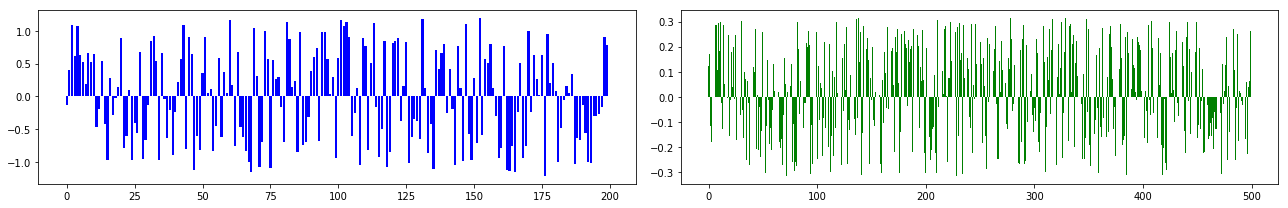


EPSILON = 7.630e-01
Iteration 1:  TOKYO, 2001 
Average Terminal Reward  = -3.702
Day Violations           =    258
Battery Limit Violations =   1866
Action MEAN              =  4.416
Action STD DEV           =  3.406


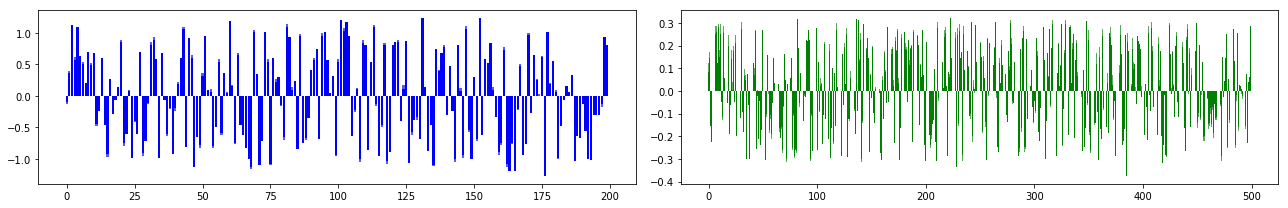


EPSILON = 7.643e-01
Iteration 2:  TOKYO, 2006 
Average Terminal Reward  = -3.981
Day Violations           =    239
Battery Limit Violations =   2379
Action MEAN              =  3.978
Action STD DEV           =  2.752


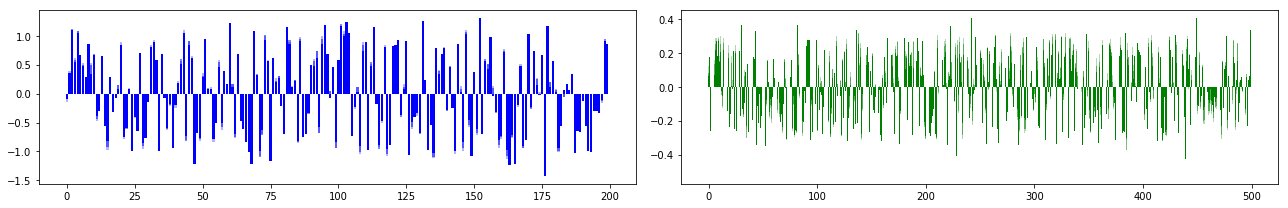


EPSILON = 7.657e-01
Iteration 3:  TOKYO, 2000 
Average Terminal Reward  = -3.526
Day Violations           =    237
Battery Limit Violations =   1922
Action MEAN              =  3.879
Action STD DEV           =  3.050


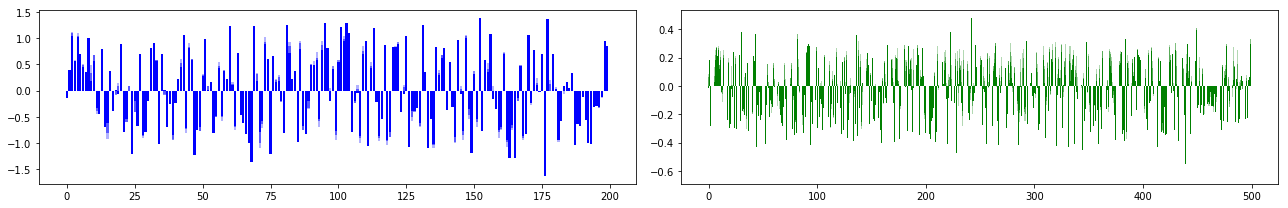


EPSILON = 7.673e-01
Iteration 4:  TOKYO, 2002 
Average Terminal Reward  = -2.113
Day Violations           =    166
Battery Limit Violations =   1313
Action MEAN              =  4.011
Action STD DEV           =  3.390


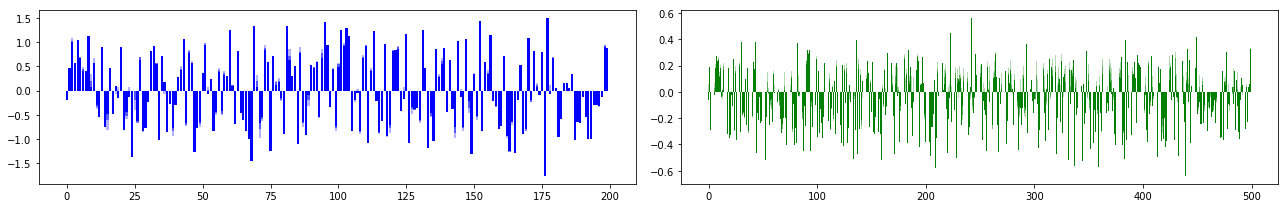


EPSILON = 7.690e-01
Iteration 5:  TOKYO, 2003 
Average Terminal Reward  = -0.096
Day Violations           =     71
Battery Limit Violations =    392
Action MEAN              =  3.383
Action STD DEV           =  3.184


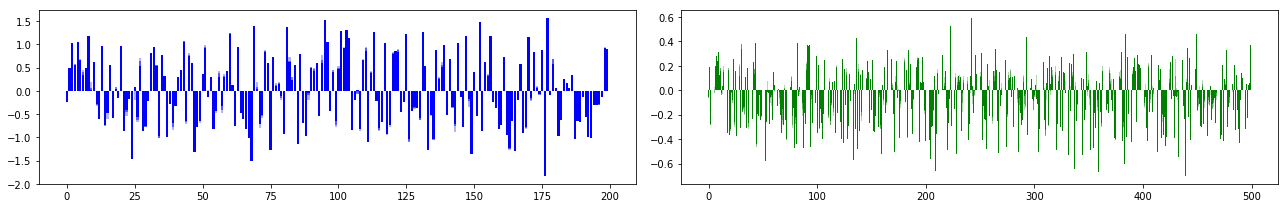


EPSILON = 7.708e-01
Iteration 6:  TOKYO, 2000 
Average Terminal Reward  = -0.562
Day Violations           =     87
Battery Limit Violations =    416
Action MEAN              =  3.629
Action STD DEV           =  3.240


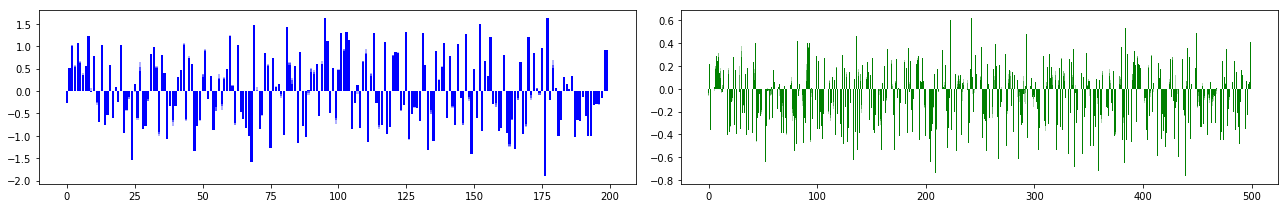


EPSILON = 7.728e-01
Iteration 7:  TOKYO, 2002 
Average Terminal Reward  = -0.639
Day Violations           =     90
Battery Limit Violations =    679
Action MEAN              =  3.762
Action STD DEV           =  3.069


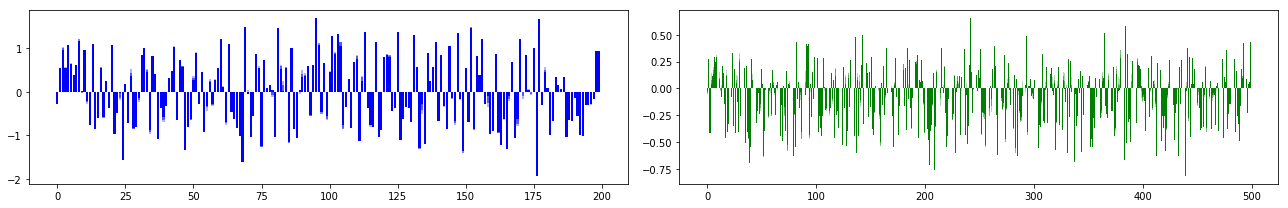


EPSILON = 7.749e-01
Iteration 8:  TOKYO, 2000 
Average Terminal Reward  = -0.955
Day Violations           =    108
Battery Limit Violations =    738
Action MEAN              =  3.789
Action STD DEV           =  3.198


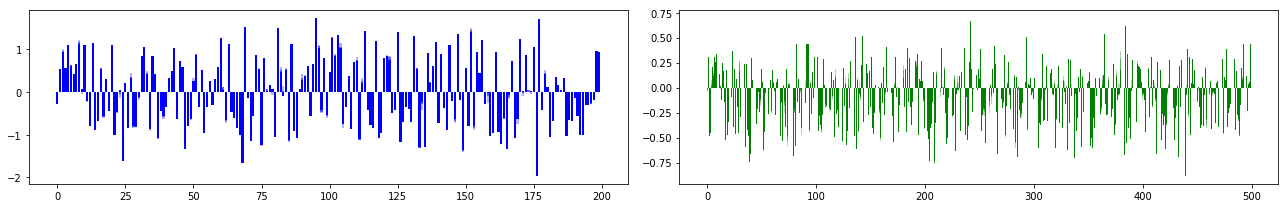


EPSILON = 7.773e-01
Iteration 9:  TOKYO, 2008 
Average Terminal Reward  = -0.247
Day Violations           =     75
Battery Limit Violations =    595
Action MEAN              =  3.765
Action STD DEV           =  3.267


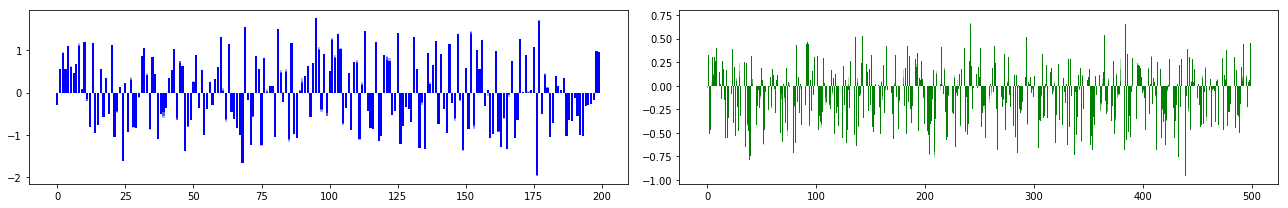


EPSILON = 7.798e-01
Iteration 10:  TOKYO, 2003 
Average Terminal Reward  =  0.068
Day Violations           =     58
Battery Limit Violations =    435
Action MEAN              =  3.416
Action STD DEV           =  3.037


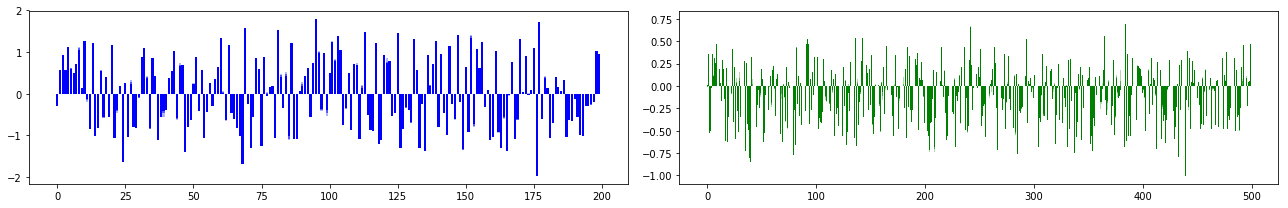


EPSILON = 7.825e-01
Iteration 11:  TOKYO, 2004 
Average Terminal Reward  =  0.043
Day Violations           =     58
Battery Limit Violations =    312
Action MEAN              =  3.762
Action STD DEV           =  3.171


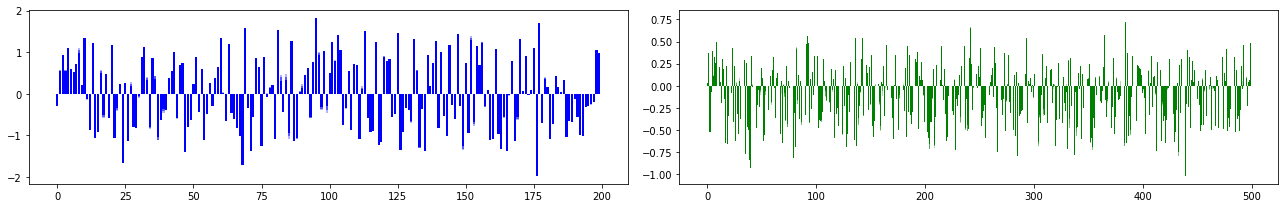


EPSILON = 7.855e-01
Iteration 12:  TOKYO, 2009 
Average Terminal Reward  = -0.063
Day Violations           =     66
Battery Limit Violations =    332
Action MEAN              =  3.473
Action STD DEV           =  3.088


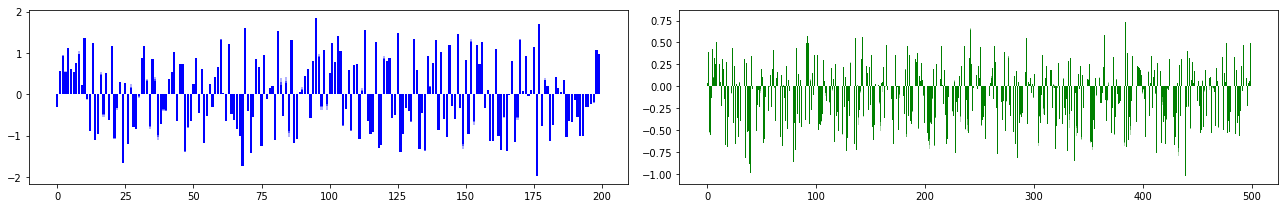


EPSILON = 7.886e-01
Iteration 13:  TOKYO, 2006 
Average Terminal Reward  = -0.446
Day Violations           =     77
Battery Limit Violations =    540
Action MEAN              =  3.332
Action STD DEV           =  2.929


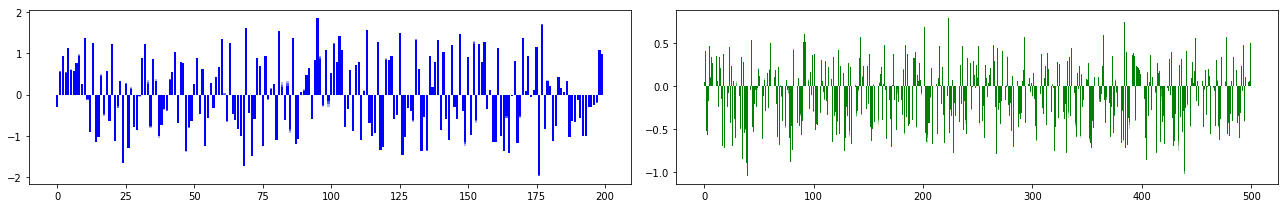


EPSILON = 7.920e-01
Iteration 14:  TOKYO, 2002 
Average Terminal Reward  = -0.438
Day Violations           =     80
Battery Limit Violations =    561
Action MEAN              =  3.650
Action STD DEV           =  3.095


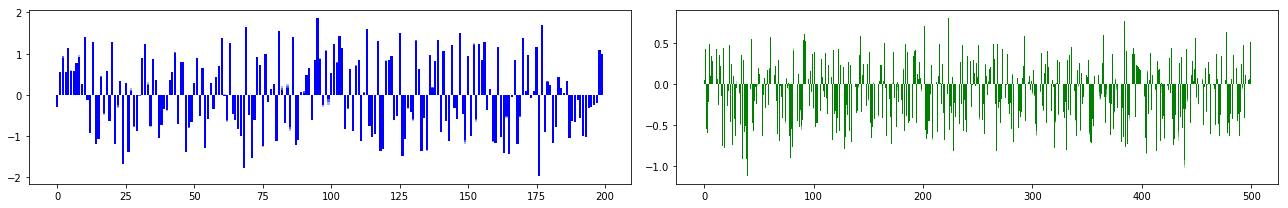


EPSILON = 7.956e-01
Iteration 15:  TOKYO, 2009 
Average Terminal Reward  = -0.322
Day Violations           =     74
Battery Limit Violations =    468
Action MEAN              =  3.572
Action STD DEV           =  3.056


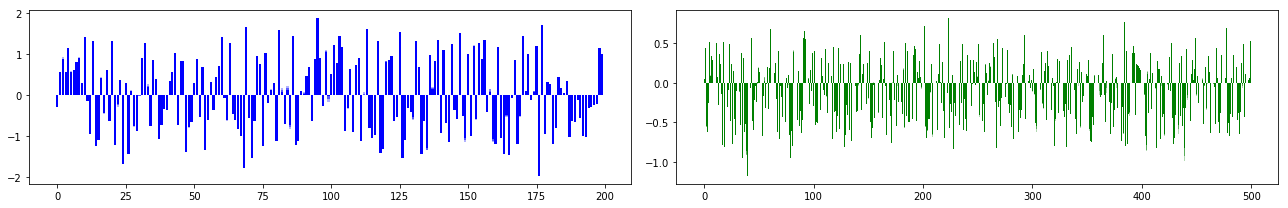


EPSILON = 7.995e-01
Iteration 16:  TOKYO, 2005 
Average Terminal Reward  =  0.769
Day Violations           =     29
Battery Limit Violations =    208
Action MEAN              =  3.523
Action STD DEV           =  3.208


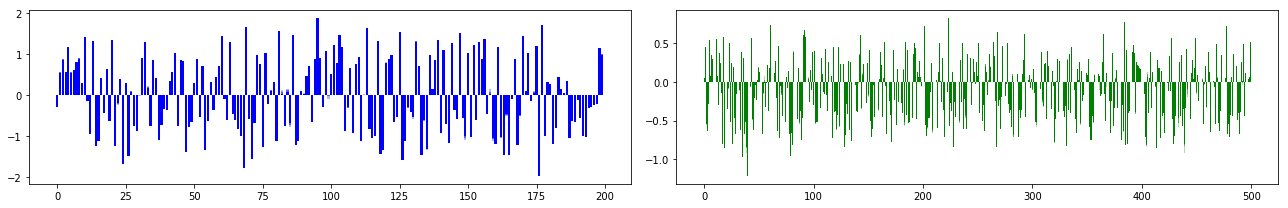


EPSILON = 8.035e-01
Iteration 17:  TOKYO, 2004 
Average Terminal Reward  =  0.773
Day Violations           =     26
Battery Limit Violations =    167
Action MEAN              =  3.715
Action STD DEV           =  3.340


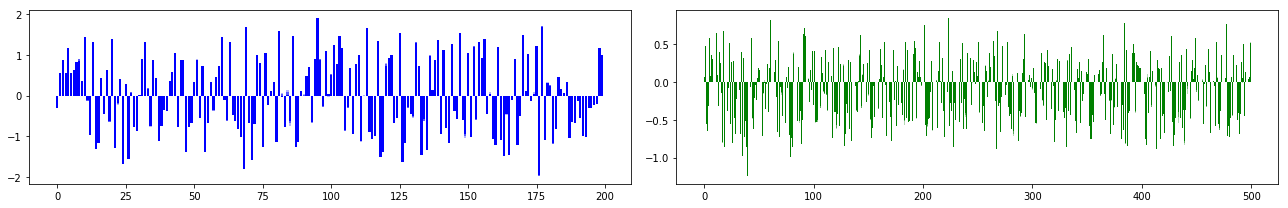


EPSILON = 8.079e-01
Iteration 18:  TOKYO, 2001 
Average Terminal Reward  =  0.814
Day Violations           =     22
Battery Limit Violations =     77
Action MEAN              =  3.428
Action STD DEV           =  3.192


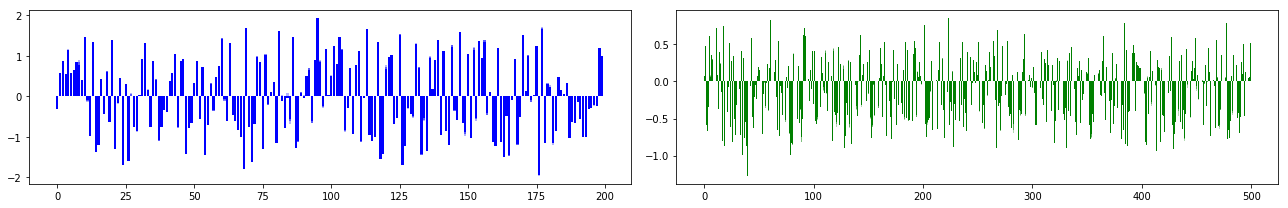


EPSILON = 8.124e-01
Iteration 19:  TOKYO, 2007 
Average Terminal Reward  =  0.694
Day Violations           =     29
Battery Limit Violations =     74
Action MEAN              =  3.504
Action STD DEV           =  3.227


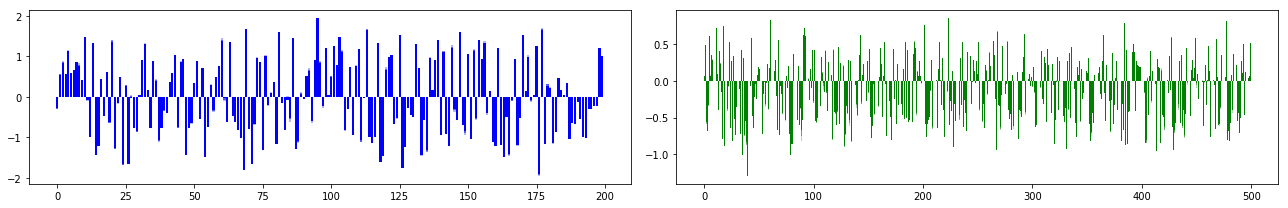


EPSILON = 8.172e-01
Iteration 20:  TOKYO, 2009 
Average Terminal Reward  =  0.645
Day Violations           =     31
Battery Limit Violations =     92
Action MEAN              =  3.355
Action STD DEV           =  3.179


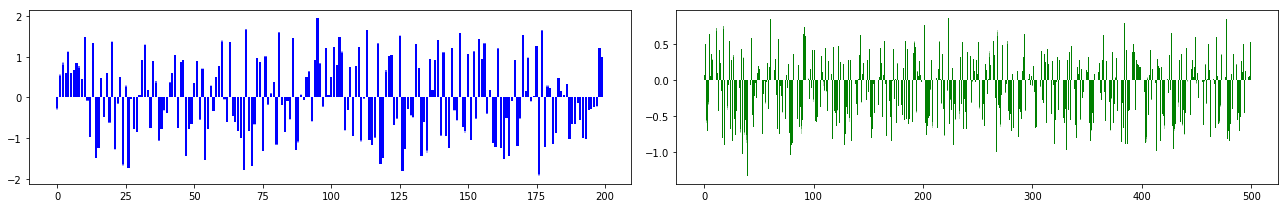


EPSILON = 8.223e-01
Iteration 21:  TOKYO, 2002 
Average Terminal Reward  =  0.322
Day Violations           =     46
Battery Limit Violations =    306
Action MEAN              =  3.492
Action STD DEV           =  3.175


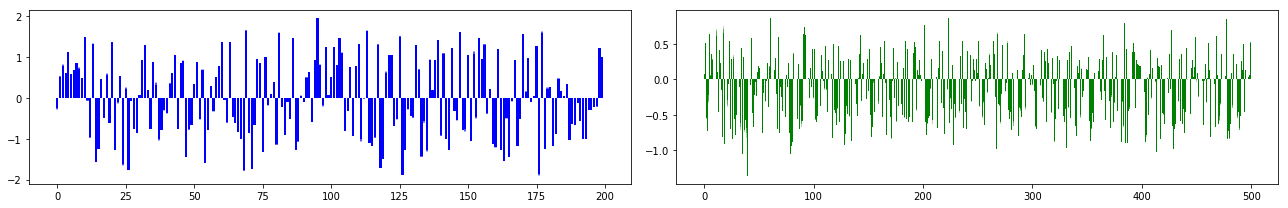


EPSILON = 8.275e-01
Iteration 22:  TOKYO, 2007 
Average Terminal Reward  =  0.815
Day Violations           =     27
Battery Limit Violations =     80
Action MEAN              =  3.510
Action STD DEV           =  3.165


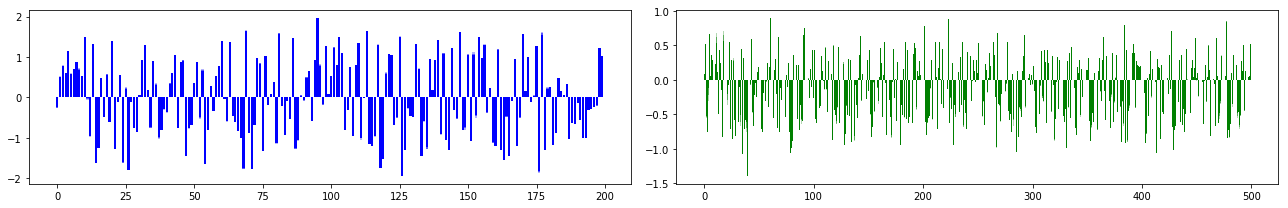


EPSILON = 8.330e-01
Iteration 23:  TOKYO, 2005 
Average Terminal Reward  =  1.129
Day Violations           =      9
Battery Limit Violations =     51
Action MEAN              =  3.437
Action STD DEV           =  3.110


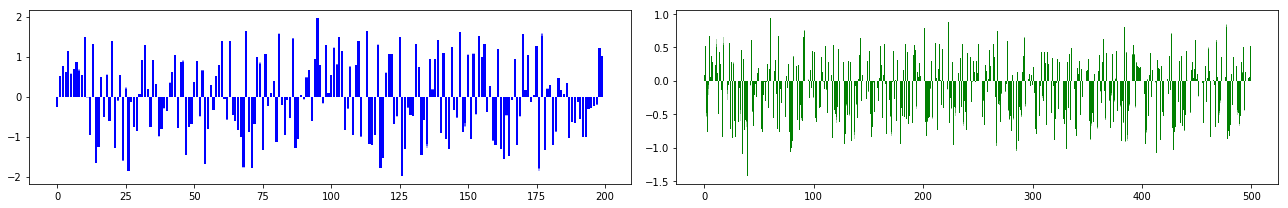


EPSILON = 8.386e-01
Iteration 24:  TOKYO, 2005 
Average Terminal Reward  =  1.028
Day Violations           =     14
Battery Limit Violations =    105
Action MEAN              =  3.484
Action STD DEV           =  3.129


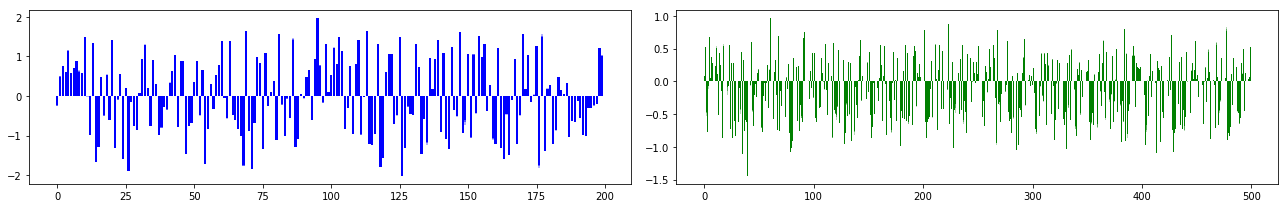


EPSILON = 8.444e-01
Iteration 25:  TOKYO, 2004 
Average Terminal Reward  =  0.764
Day Violations           =     27
Battery Limit Violations =    146
Action MEAN              =  3.641
Action STD DEV           =  3.224


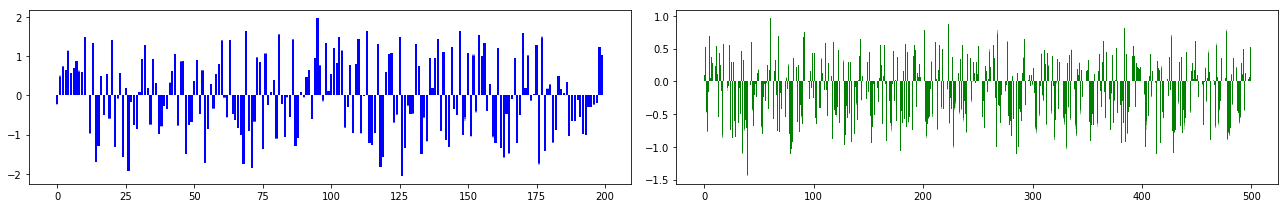


EPSILON = 8.503e-01
Iteration 26:  TOKYO, 2003 
Average Terminal Reward  =  0.675
Day Violations           =     30
Battery Limit Violations =    136
Action MEAN              =  3.227
Action STD DEV           =  2.969


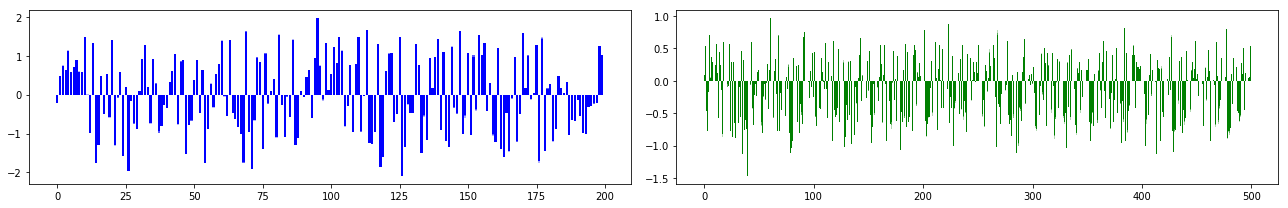


EPSILON = 8.564e-01
Iteration 27:  TOKYO, 2002 
Average Terminal Reward  =  0.661
Day Violations           =     29
Battery Limit Violations =    108
Action MEAN              =  3.432
Action STD DEV           =  3.156


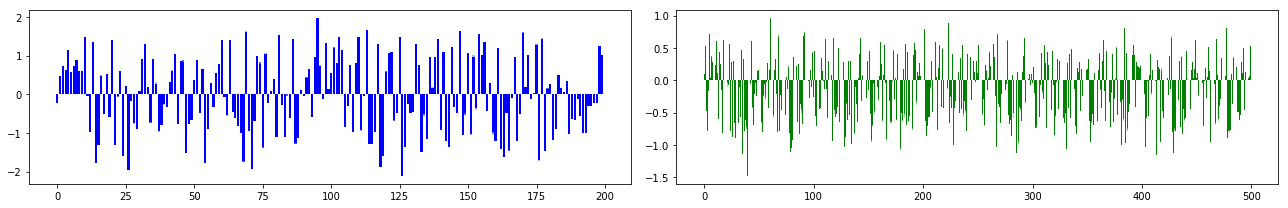


EPSILON = 8.625e-01
Iteration 28:  TOKYO, 2009 
Average Terminal Reward  =  0.795
Day Violations           =     27
Battery Limit Violations =    126
Action MEAN              =  3.377
Action STD DEV           =  3.108


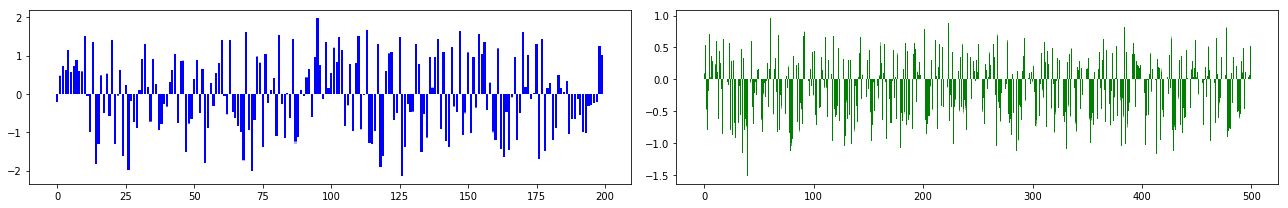


EPSILON = 8.688e-01
Iteration 29:  TOKYO, 2000 
Average Terminal Reward  =  1.085
Day Violations           =     12
Battery Limit Violations =     49
Action MEAN              =  3.402
Action STD DEV           =  3.186


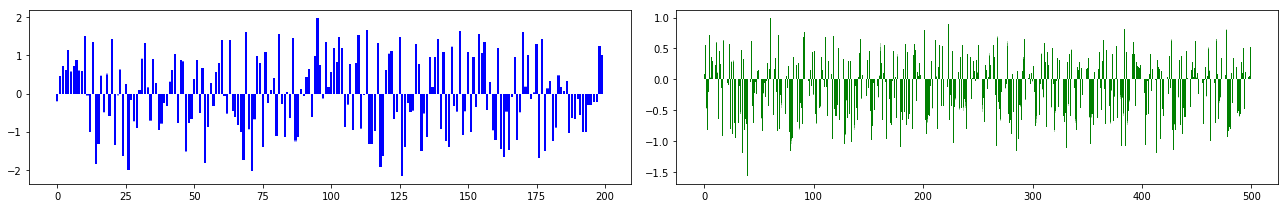


EPSILON = 8.750e-01
Iteration 30:  TOKYO, 2006 
Average Terminal Reward  =  1.052
Day Violations           =     13
Battery Limit Violations =      0
Action MEAN              =  3.044
Action STD DEV           =  3.000


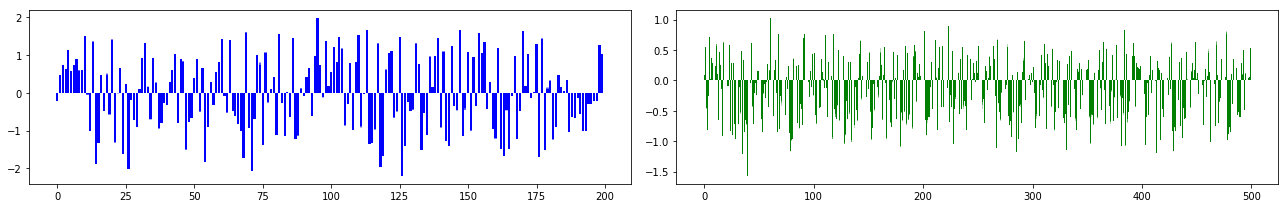


EPSILON = 8.812e-01
Iteration 31:  TOKYO, 2008 
Average Terminal Reward  =  1.095
Day Violations           =      9
Battery Limit Violations =     66
Action MEAN              =  3.384
Action STD DEV           =  3.108


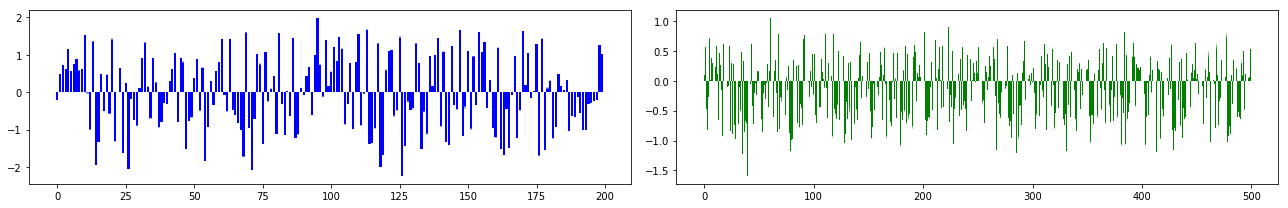


EPSILON = 8.875e-01
Iteration 32:  TOKYO, 2001 
Average Terminal Reward  =  1.276
Day Violations           =      5
Battery Limit Violations =      0
Action MEAN              =  3.393
Action STD DEV           =  3.144


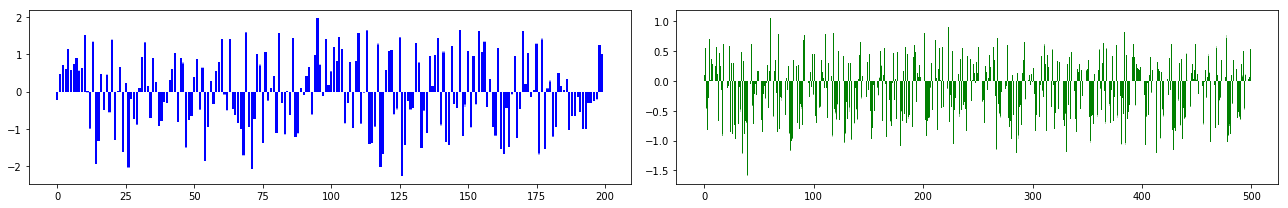


EPSILON = 8.936e-01
Iteration 33:  TOKYO, 2004 
Average Terminal Reward  =  1.055
Day Violations           =     16
Battery Limit Violations =     44
Action MEAN              =  3.604
Action STD DEV           =  3.279


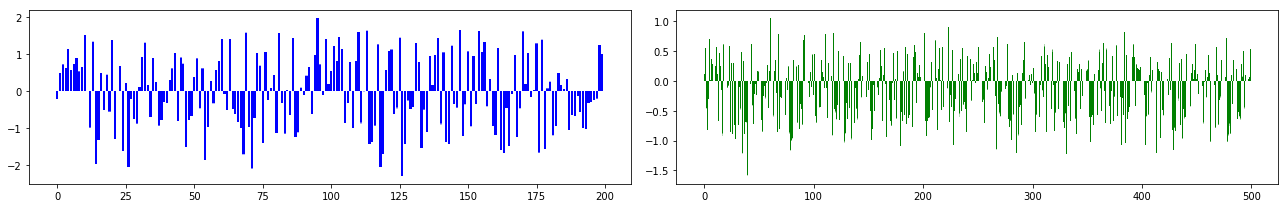


EPSILON = 8.997e-01
Iteration 34:  TOKYO, 2009 
Average Terminal Reward  =  1.266
Day Violations           =      3
Battery Limit Violations =      0
Action MEAN              =  3.317
Action STD DEV           =  3.174


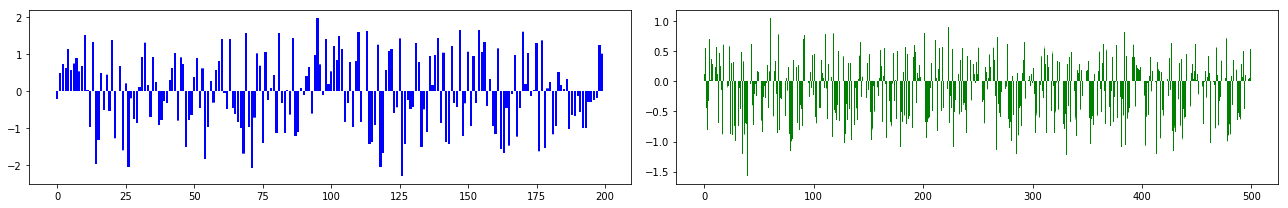


EPSILON = 9.056e-01
Iteration 35:  TOKYO, 2009 
Average Terminal Reward  =  1.214
Day Violations           =      6
Battery Limit Violations =      3
Action MEAN              =  3.317
Action STD DEV           =  3.092


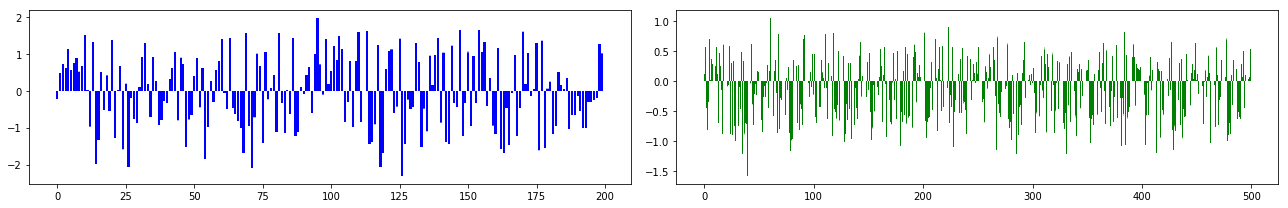


EPSILON = 9.114e-01
Iteration 36:  TOKYO, 2001 
Average Terminal Reward  =  1.317
Day Violations           =      3
Battery Limit Violations =      0
Action MEAN              =  3.395
Action STD DEV           =  3.154


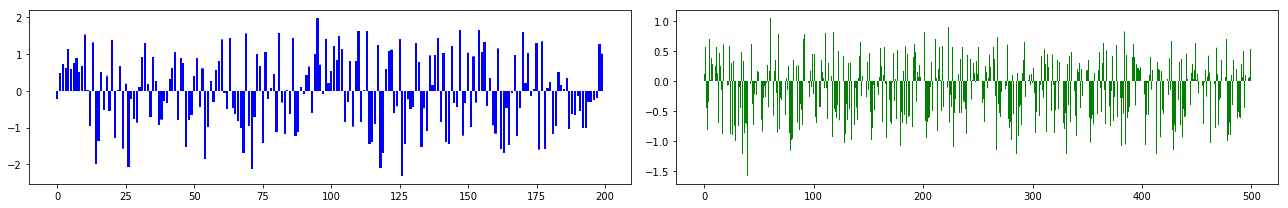


EPSILON = 9.170e-01
Iteration 37:  TOKYO, 2003 
Average Terminal Reward  =  1.151
Day Violations           =     10
Battery Limit Violations =     70
Action MEAN              =  3.171
Action STD DEV           =  2.976


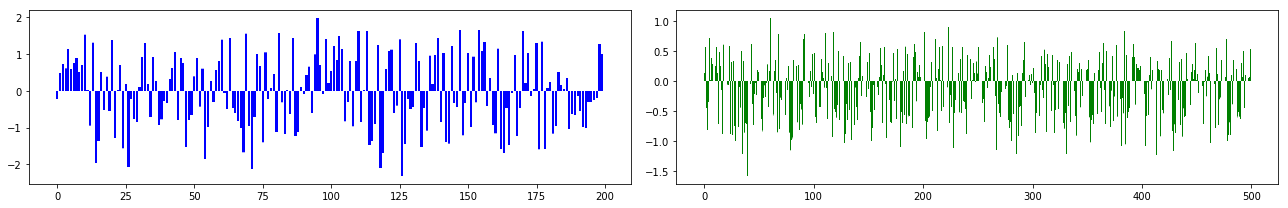


EPSILON = 9.225e-01
Iteration 38:  TOKYO, 2008 
Average Terminal Reward  =  1.300
Day Violations           =      2
Battery Limit Violations =      3
Action MEAN              =  3.357
Action STD DEV           =  3.063


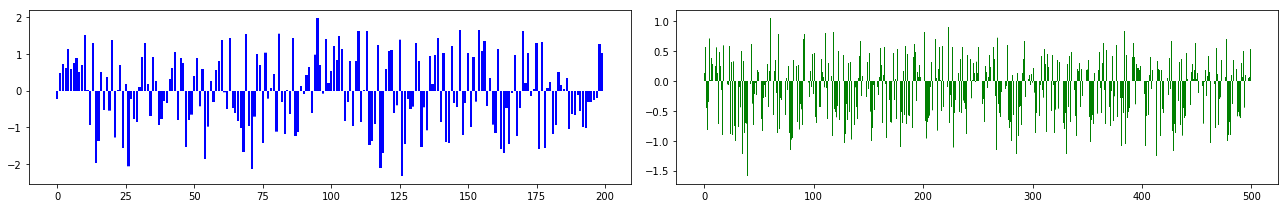


EPSILON = 9.277e-01
Iteration 39:  TOKYO, 2009 
Average Terminal Reward  =  1.236
Day Violations           =      4
Battery Limit Violations =      0
Action MEAN              =  3.317
Action STD DEV           =  3.090


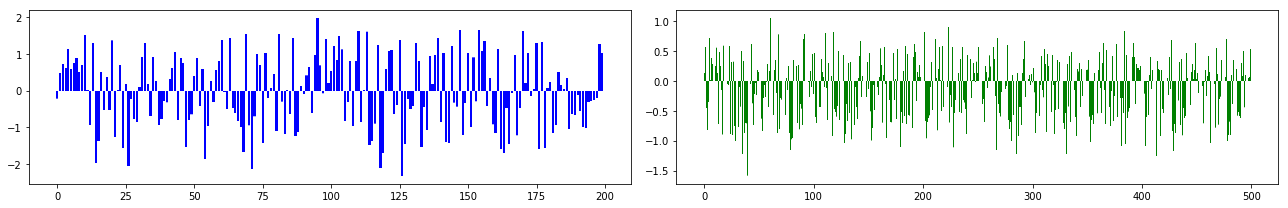


EPSILON = 9.328e-01
Iteration 40:  TOKYO, 2004 
Average Terminal Reward  =  1.228
Day Violations           =      6
Battery Limit Violations =      0
Action MEAN              =  3.595
Action STD DEV           =  3.264


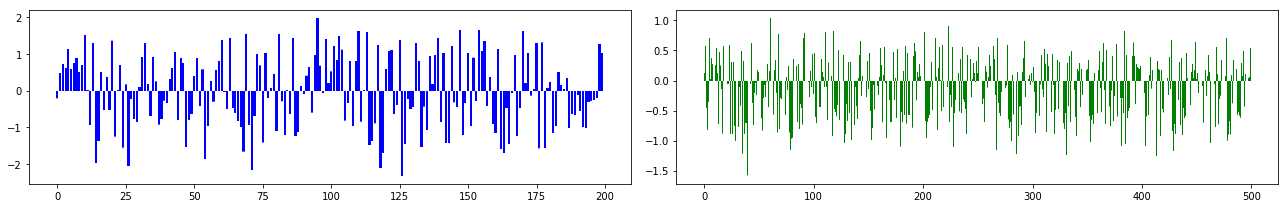


EPSILON = 9.376e-01
Iteration 41:  TOKYO, 2005 
Average Terminal Reward  =  1.356
Day Violations           =      0
Battery Limit Violations =      0
Action MEAN              =  3.413
Action STD DEV           =  3.029


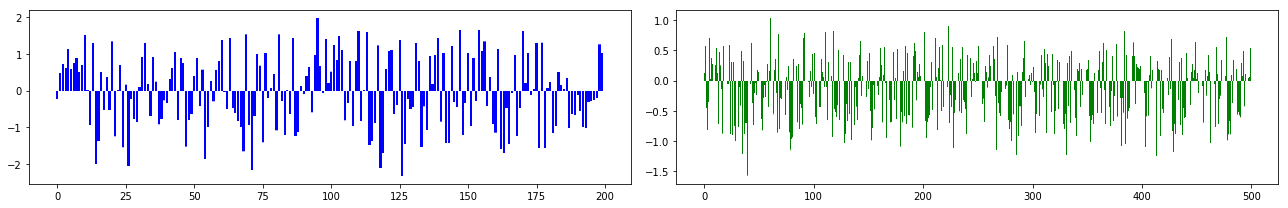


EPSILON = 9.421e-01
Iteration 42:  TOKYO, 2009 
Average Terminal Reward  =  1.371
Day Violations           =      0
Battery Limit Violations =      0
Action MEAN              =  3.318
Action STD DEV           =  2.974


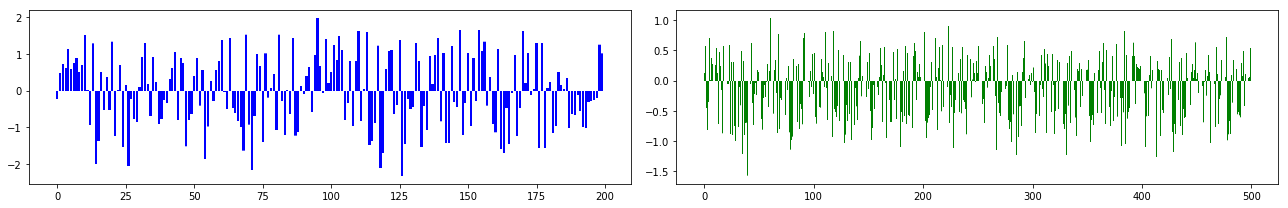


EPSILON = 9.465e-01
Iteration 43:  TOKYO, 2003 
Average Terminal Reward  =  1.270
Day Violations           =      3
Battery Limit Violations =      2
Action MEAN              =  3.156
Action STD DEV           =  2.931


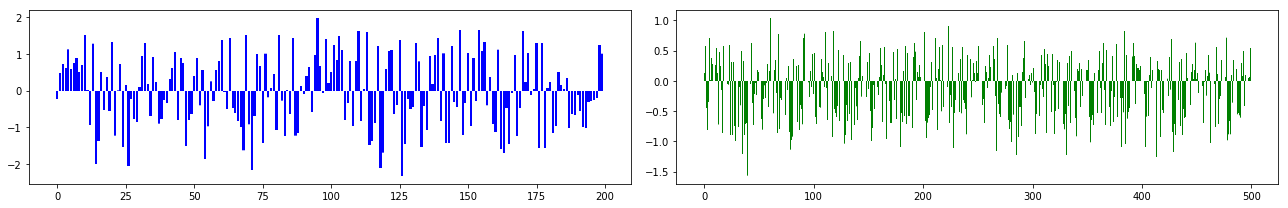


EPSILON = 9.505e-01
Iteration 44:  TOKYO, 2000 
Average Terminal Reward  =  1.325
Day Violations           =      0
Battery Limit Violations =      0
Action MEAN              =  3.376
Action STD DEV           =  3.058


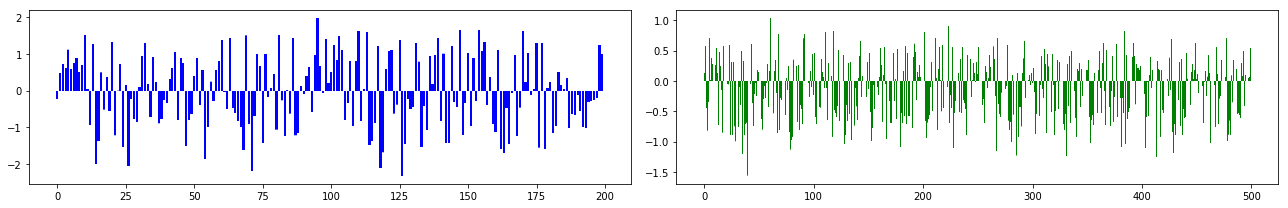


EPSILON = 9.544e-01
Iteration 45:  TOKYO, 2000 
Average Terminal Reward  =  1.363
Day Violations           =      0
Battery Limit Violations =      0
Action MEAN              =  3.376
Action STD DEV           =  3.135


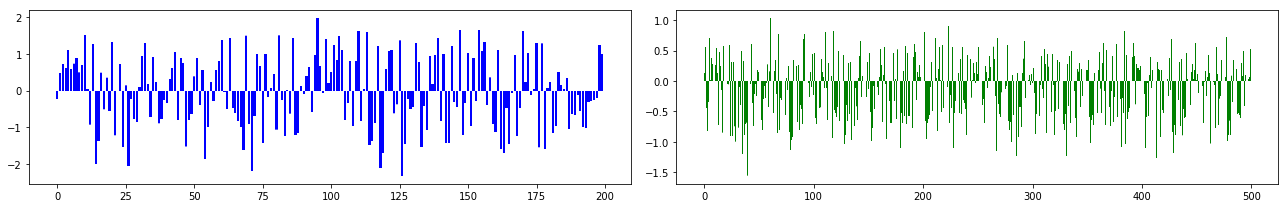


EPSILON = 9.580e-01
Iteration 46:  TOKYO, 2005 
Average Terminal Reward  =  1.380
Day Violations           =      0
Battery Limit Violations =      0
Action MEAN              =  3.413
Action STD DEV           =  3.131


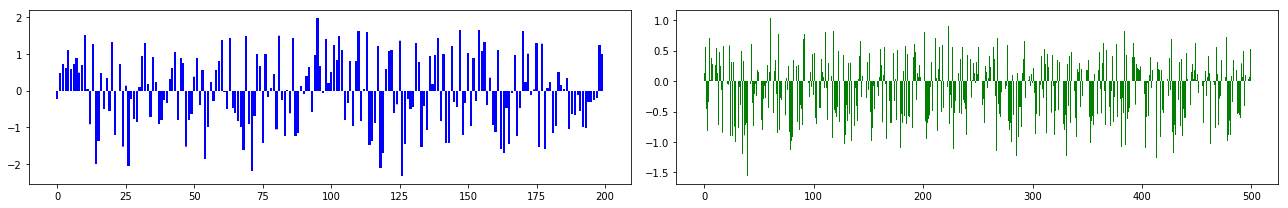


EPSILON = 9.614e-01
Iteration 47:  TOKYO, 2003 
Average Terminal Reward  =  1.290
Day Violations           =      3
Battery Limit Violations =      0
Action MEAN              =  3.157
Action STD DEV           =  2.978


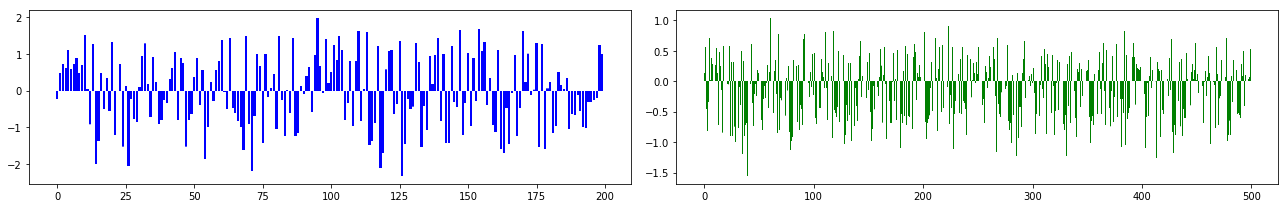


EPSILON = 9.645e-01
Iteration 48:  TOKYO, 2006 
Average Terminal Reward  =  1.326
Day Violations           =      0
Battery Limit Violations =      0
Action MEAN              =  3.043
Action STD DEV           =  2.887


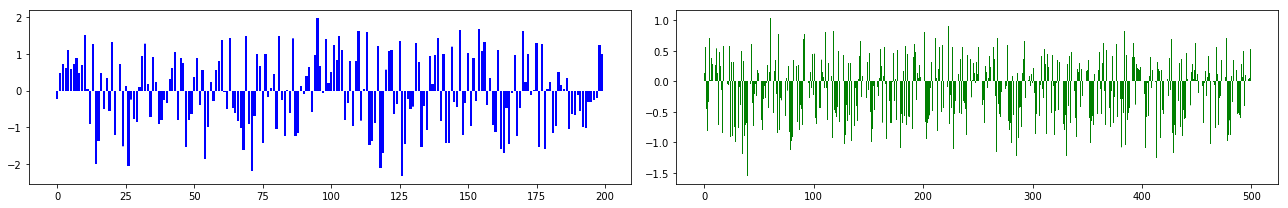


EPSILON = 9.675e-01
Iteration 49:  TOKYO, 2006 
Average Terminal Reward  =  1.361
Day Violations           =      0
Battery Limit Violations =      0
Action MEAN              =  3.043
Action STD DEV           =  2.919


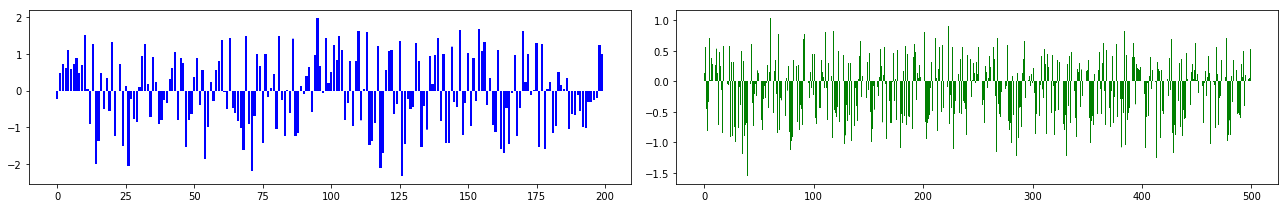

In [10]:
#TRAIN 
dqn = DQN()
# for recording weights
oldfc1 = dqn.eval_net.fc1.weight.data.cpu().numpy().flatten()
old2fc1 = oldfc1

# oldfc2 = dqn.eval_net.fc2.weight.data.cpu().numpy().flatten()
# old2fc2 = oldfc2

# oldfc3 = dqn.eval_net.fc3.weight.data.cpu().numpy().flatten()
# old2fc3 = oldfc3

oldout = dqn.eval_net.fc_out.weight.data.cpu().numpy().flatten()
old2out = oldout
########################################

best_iteration = -1
best_avg_reward = -1000 #initialize best average reward to very low value
reset_counter = 0 #count number of times the battery had to be reset
change_hr = 0
# PFILENAME = ''.join(random.choice(string.ascii_uppercase + string.digits) for _ in range(8)) #create random filename
# BFILENAME = "best"+PFILENAME + ".pt" #this file stores the best model
# TFILENAME = "terminal"+PFILENAME + ".pt" #this file stores the last model

avg_reward_rec = [] #record the yearly average rewards over the entire duration of training
batt_violation_rec = []
day_violation_rec = []

print('\nTRAINING IN PROGRESS\n')
print('Device: ', dqn.device)

for iteration in range(NO_OF_ITERATIONS):
    # EPSILON SCHEDULING
    slope = 10
    start = 0.75
    inflection_point = 30
    EPSILON = start + (1-start)/(1 + np.exp(-(iteration-inflection_point)/slope))
    print('\nEPSILON = {:6.3e}'.format(EPSILON))

    # LR SCEHDULING
    lr_slope = 3
    lr_start = 0
    lr_inflection_point = 2
    if iteration <=30:
        lrate =  (lr_start + (1-lr_start)/(1 + np.exp(-(iteration-lr_inflection_point)/lr_slope)))*1e-4
    else:
        lrate = 0.8*lrate
    dqn.optimizer = torch.optim.Adam(dqn.eval_net.parameters(), lr=lrate)
#     dqn.optimizer = torch.optim.Adam(dqn.eval_net.parameters(), lr=lrate, weight_decay=WT_DECAY)

    
    LOCATION    = 'tokyo'#random.choice(['tokyo','wakkanai','minamidaito'])
    YEAR        = random.choice(np.arange(2000,2010))
    
    capm        = CAPM(LOCATION,YEAR,shuffle=False, trainmode=False) #instantiate the CAPM class
    capm.eno    = ENO(LOCATION,YEAR, shuffle=False, day_balance=False) #instantiate the environment inside the CAPM class
    capm.HMAX   = capm.eno.SMAX #maximum power output of solar cell is set in CAPM object using the value in ENO object

    print('Iteration {}:  {}, {} '.format(iteration, LOCATION.upper(), YEAR))

    s, r, day_end, year_end = capm.reset()
    yr_record      = np.empty(4)
#     record         = np.empty(4) #record for battery, henergy, reward and action
    transition_rec = np.zeros((capm.eno.TIME_STEPS, N_STATES * 2 + 2)) #record all the transition in one day

    while True:
        a = dqn.choose_action(stdize(s))

        # present state = [batt, enp, henergy]
#         record    = np.vstack((record,    [s[0],s[2],r, a])) # record battery, henergy, reward and action for troubleshooting
        yr_record = np.vstack((yr_record, [s[0],s[2],r, a]))

        # take action
        s_, r, day_end, year_end = capm.step(a)
        
        temp_transitions                = np.hstack((stdize(s), [a, r], stdize(s_)))
        transition_rec[capm.eno.hr-1,:] = temp_transitions

        if (day_end):
            transition_rec[:,5] += r #broadcast reward to all states
            decay_factor         = [i for i in (LAMBDA**n for n in reversed(range(0, capm.eno.TIME_STEPS)))]
            transition_rec[:,5]  = transition_rec[:,5] * decay_factor #decay reward proportionately
            dqn.store_day_transition(transition_rec)

        if dqn.memory_counter > MEMORY_CAPACITY:
            dqn.learn()

        if dqn.nettoggle:
            change_hr = capm.eno.day*24+capm.eno.hr #to mark when the DQN is updated.
            dqn.nettoggle = not dqn.nettoggle

        if (year_end):
            break

        # transition to new state
        s = s_

#     record = np.delete(record, 0, 0) #remove the first row which is garbage
#     reward_rec = record[:,2]         #extract reward information from the record array
#     reward_rec = reward_rec[::24]    #only consider terminal rewards

    yr_record = np.delete(yr_record, 0, 0)     #remove the first row which is garbage
    hourly_yr_reward_rec = yr_record[:,2]      #extract reward information from the record array
    yr_reward_rec = hourly_yr_reward_rec[::24] #only consider terminal rewards
    
    print("Average Terminal Reward  = {:6.3f}".format(np.mean(yr_reward_rec)))
    print("Day Violations           = {:6d}".format(capm.violation_counter))
    print("Battery Limit Violations = {:6d}".format(capm.batt_violations))
    print("Action MEAN              = {:6.3f}".format(np.mean(yr_record[:,-1] + 1)))
    print("Action STD DEV           = {:6.3f}".format(np.std(yr_record[:,-1] + 1)))

   
    # Log the average reward in avg_reward_rec to plot later in the learning curve graph figure
    avg_reward_rec      = np.append(avg_reward_rec, np.mean(yr_reward_rec))
    day_violation_rec   = np.append(day_violation_rec, capm.violation_counter)
    batt_violation_rec  = np.append(batt_violation_rec, capm.batt_violations)
    
###########################################################################################
#   PLOT battery levels, hourly rewards and the weights

    fig = plt.figure(figsize=(18,3))
    ax1 = fig.add_subplot(121)
    newfc1 = dqn.eval_net.fc1.weight.data.cpu().numpy().flatten()
    xaxis = np.arange(0,newfc1.shape[0])
    ax1.bar(xaxis, old2fc1, color='b', alpha = 0.3)
    ax1.bar(xaxis, oldfc1,  color='b', alpha = 0.5)
    ax1.bar(xaxis, newfc1,  color='b', alpha = 1.0)
#     ax1.plot(xaxis, old2fc1, color='b', alpha = 0.2)
#     ax1.plot(xaxis, oldfc1,  color='b', alpha = 0.3)
#     ax1.plot(xaxis, newfc1,  color='b', alpha = 0.4)
#     ax1.hist(old2fc1, density = False, bins=HIDDEN_LAYER, rwidth=0.95, color='b' , alpha = 0.1 )
#     ax1.hist(oldfc1,  density = False, bins=HIDDEN_LAYER, rwidth=0.95, color='b' , alpha = 0.3 )
#     ax1.hist(newfc1,  density = False, bins=HIDDEN_LAYER, rwidth=0.95, color='b' , alpha = 0.6 )
    old2fc1 = oldfc1
    oldfc1 = newfc1
    
#     ax2 = fig.add_subplot(142)
#     newfc2 = dqn.eval_net.fc2.weight.data.cpu().numpy().flatten()
#     ax2.plot(old2fc2,color='y', alpha=0.4)
#     ax2.plot(oldfc2,color='y',alpha = 0.7)
#     ax2.plot(newfc2,color='y')
#     old2fc2 = oldfc2
#     oldfc2 = newfc2
    
#     ax3 = fig.add_subplot(143)
#     newfc3 = dqn.eval_net.fc3.weight.data.cpu().numpy().flatten()
#     ax3.plot(old2fc3,color='y', alpha=0.4)
#     ax3.plot(oldfc3,color='y',alpha = 0.7)
#     ax3.plot(newfc3,color='y')
#     old2fc3 = oldfc3
#     oldfc3 = newfc3
    
    axO = fig.add_subplot(122)
    newout = dqn.eval_net.fc_out.weight.data.cpu().numpy().flatten()
    xaxis = np.arange(0,newout.shape[0])
    axO.bar(xaxis, old2out, color='g', alpha = 0.3)
    axO.bar(xaxis, oldout,  color='g', alpha = 0.5)
    axO.bar(xaxis, newout,  color='g', alpha = 1.0)
#     axO.plot(old2out, color='g', alpha = 0.2)
#     axO.plot(oldout,  color='g', alpha = 0.3)
#     axO.plot(newout,  color='g', alpha = 0.4)
#     axO.hist(old2out, density = False, bins=HIDDEN_LAYER, rwidth=0.95, color='g' , alpha = 0.1)
#     axO.hist(oldout,  density = False, bins=HIDDEN_LAYER, rwidth=0.95, color='g' , alpha = 0.3)
#     axO.hist(newout,  density = False, bins=HIDDEN_LAYER, rwidth=0.95, color='g' , alpha = 0.6)
    old2out = oldout
    oldout = newout
    
    fig.tight_layout()
    plt.show()


    # End of training

In [11]:
print('Device: ', dqn.device)
print('Train time: {}'.format(datetime.now() - tic))
torch.save(dqn.eval_net.state_dict(), FILENAME)

Device:  cpu
Train time: 0:22:30.001399


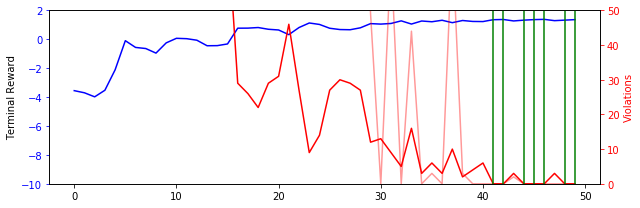

In [12]:
fig = plt.figure(figsize=(9,3))
# Plot the average reward log

ax1 = fig.add_subplot(111)
ax1.set_ylabel("Terminal Reward")
ax1.set_ylim([-10,2]);
ax1.plot(avg_reward_rec,'b')
ax1.tick_params(axis='y', colors='b')

#Plot the violation record log
ax2 = ax1.twinx()
ax2.set_ylabel("Violations",color = 'r')
ax2.plot(day_violation_rec,'r')
ax2.plot(batt_violation_rec,'r',alpha=0.4)
for xpt in np.argwhere(day_violation_rec<1):
    ax2.axvline(x=xpt,color='g')
ax2.set_ylim([0,50]);
ax2.tick_params(axis='y', colors='r')
fig.tight_layout()

***MEASURING PERFORMANCE OF THE MODEL***


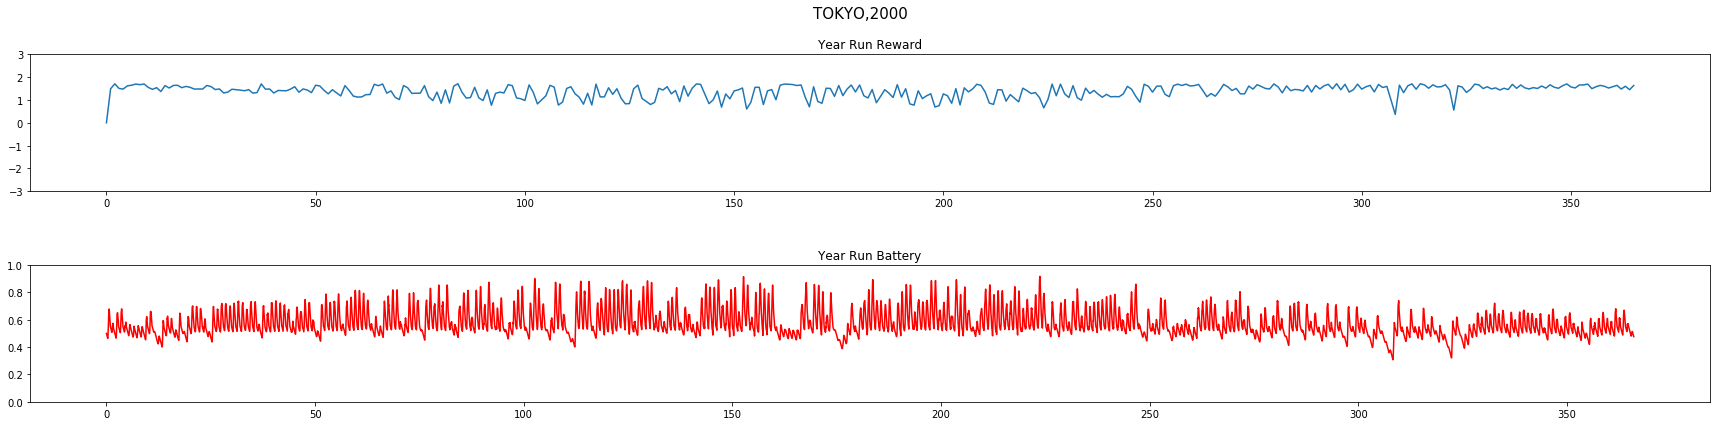

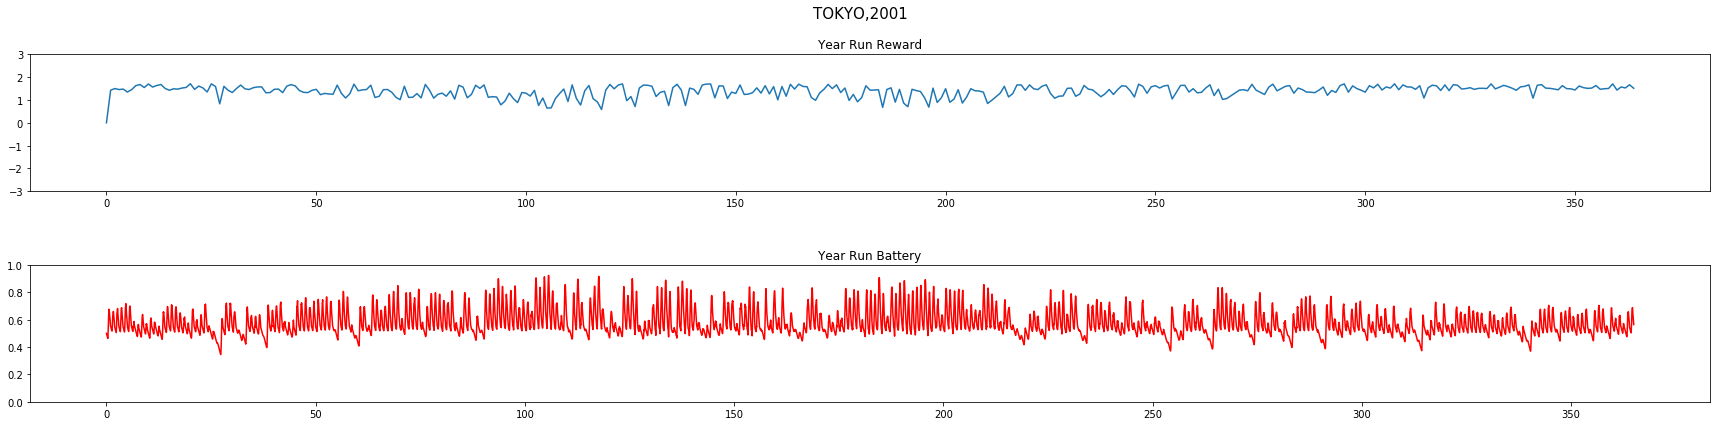

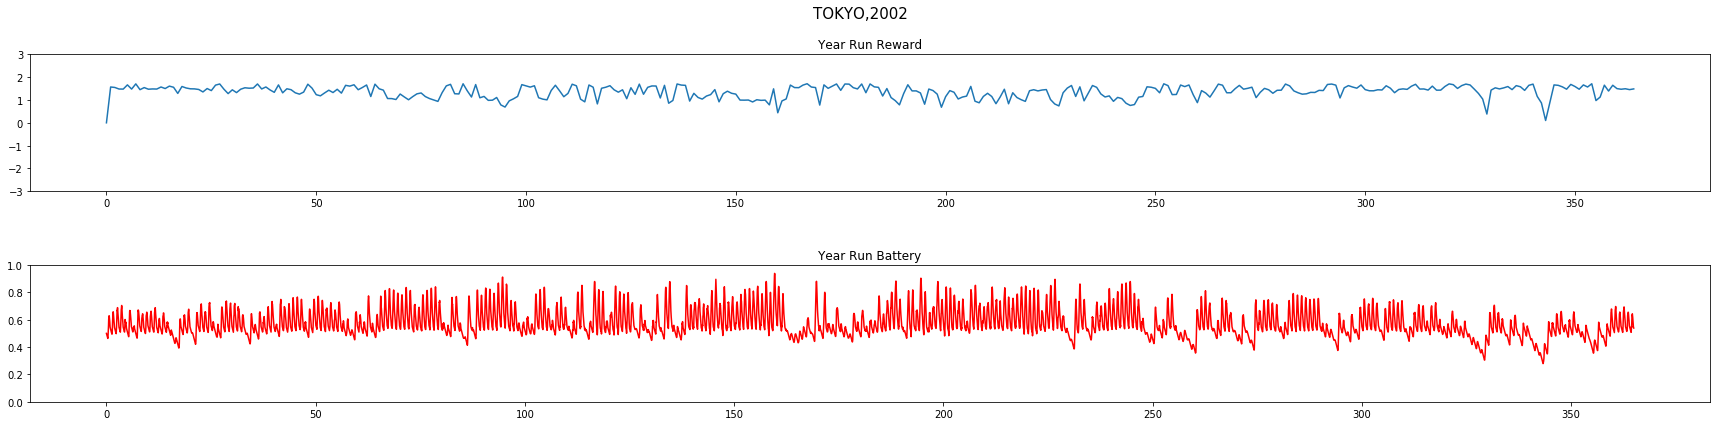

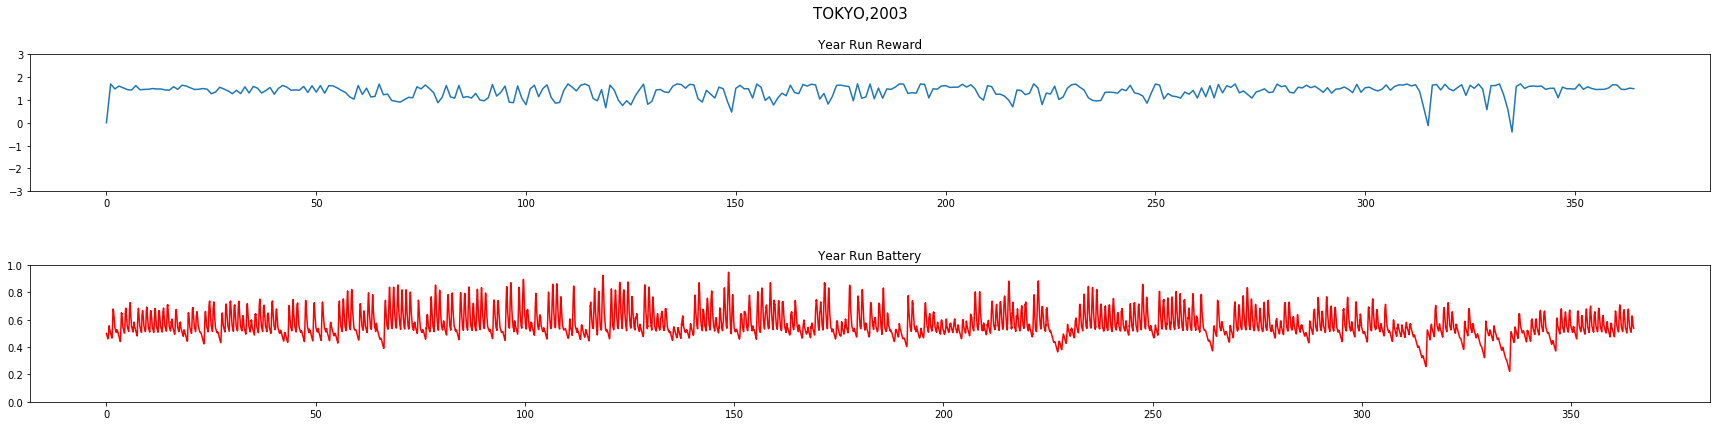

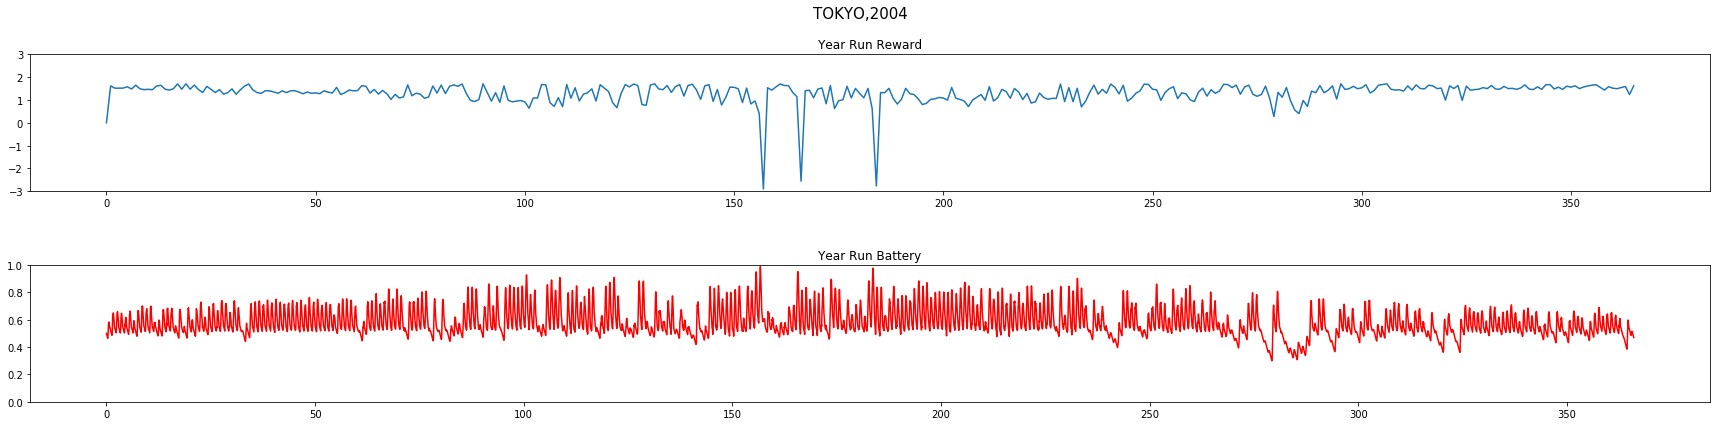

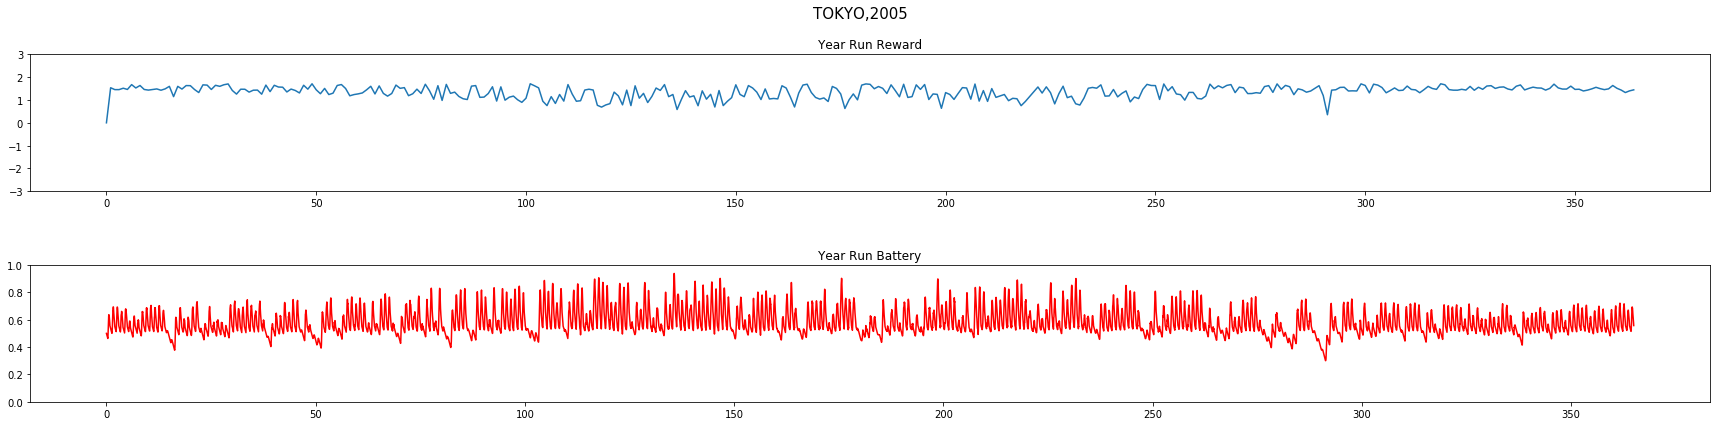

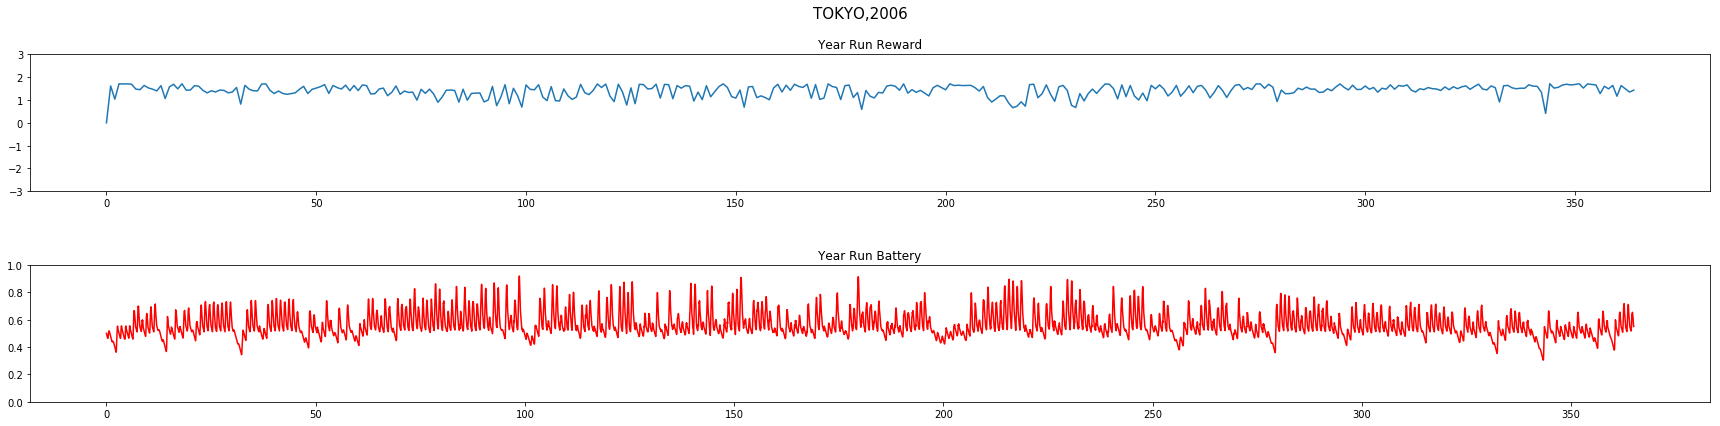

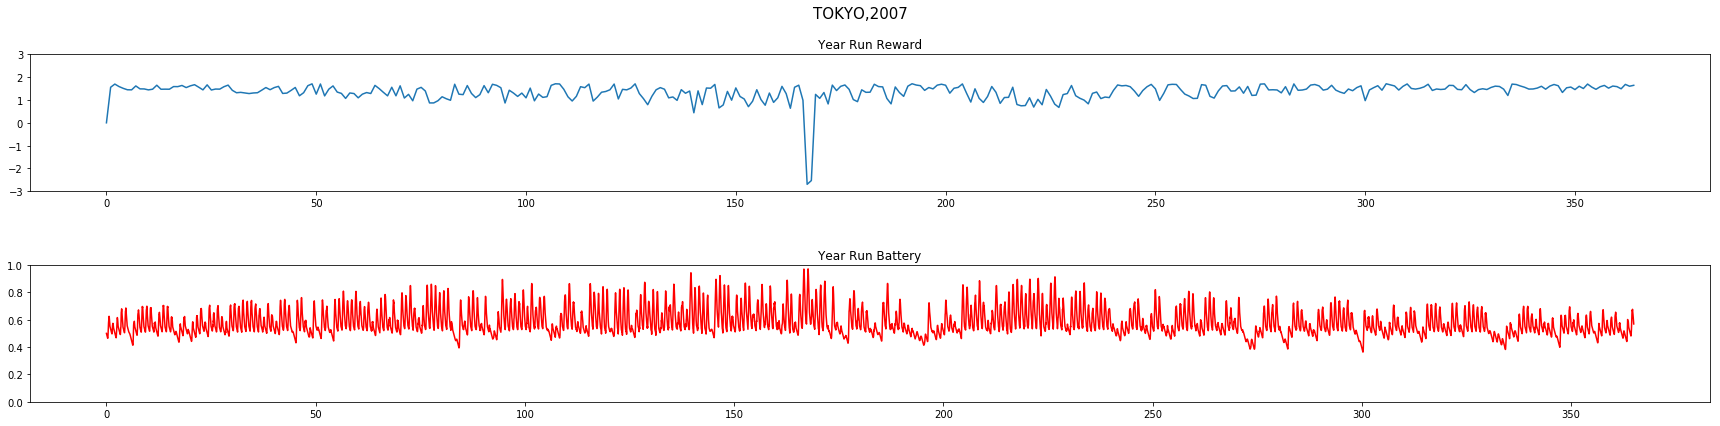

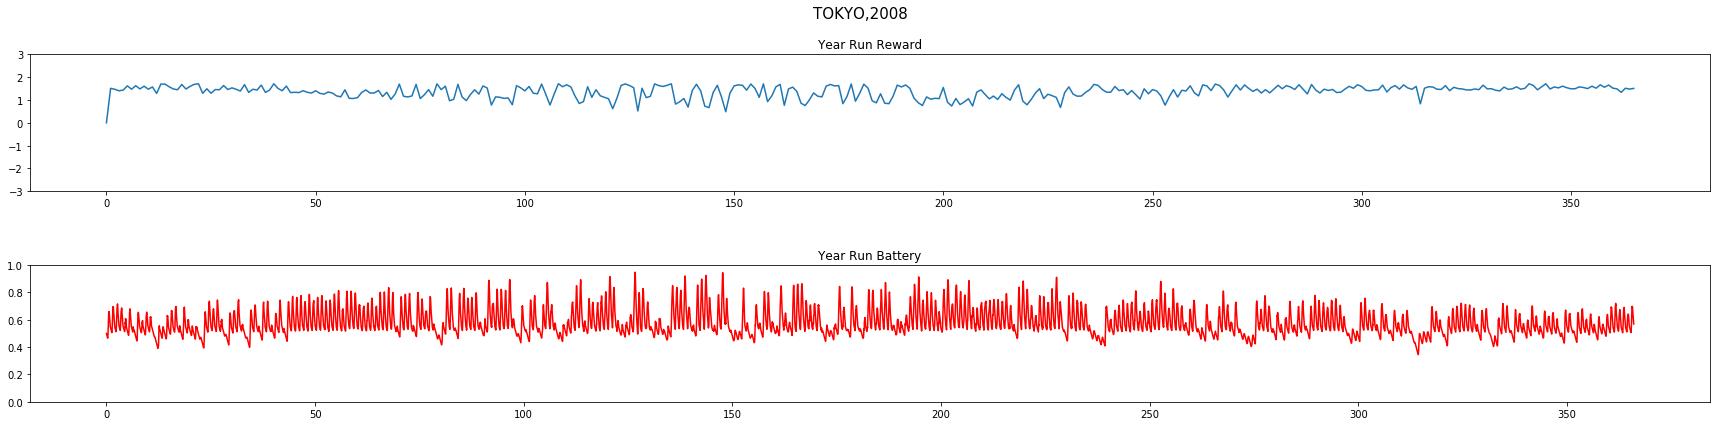

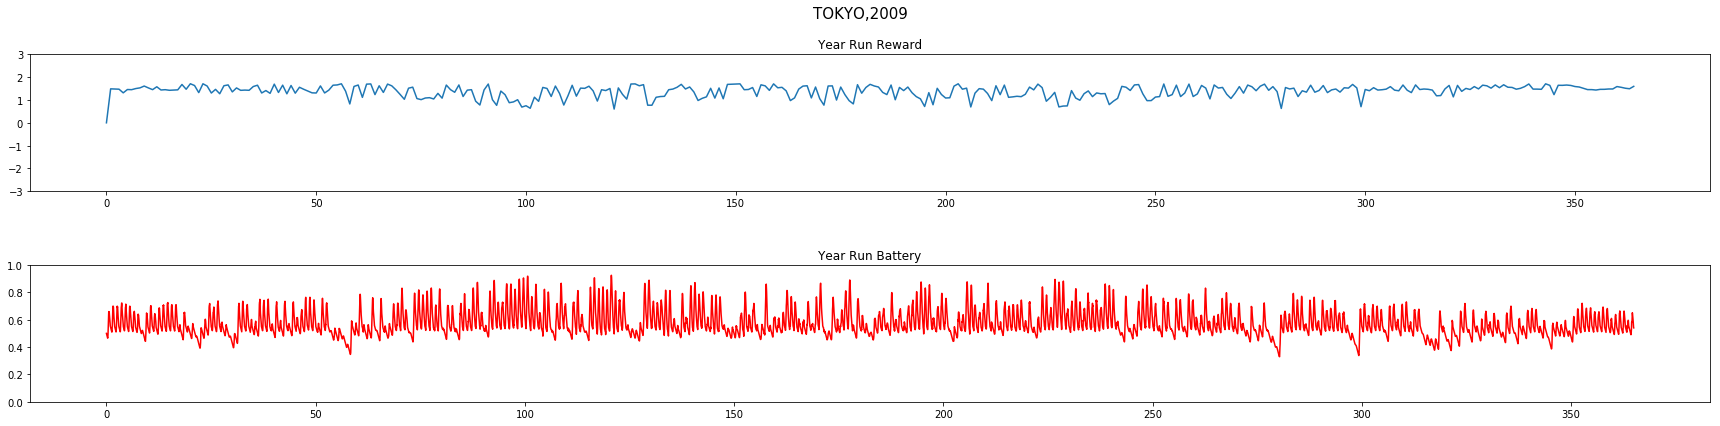

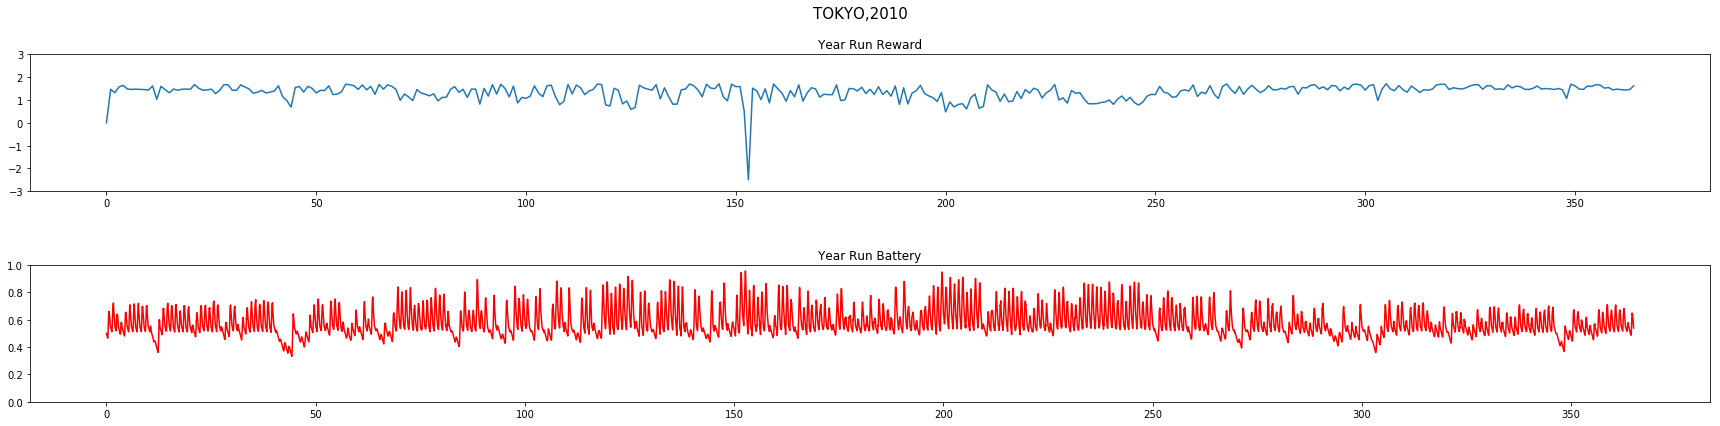

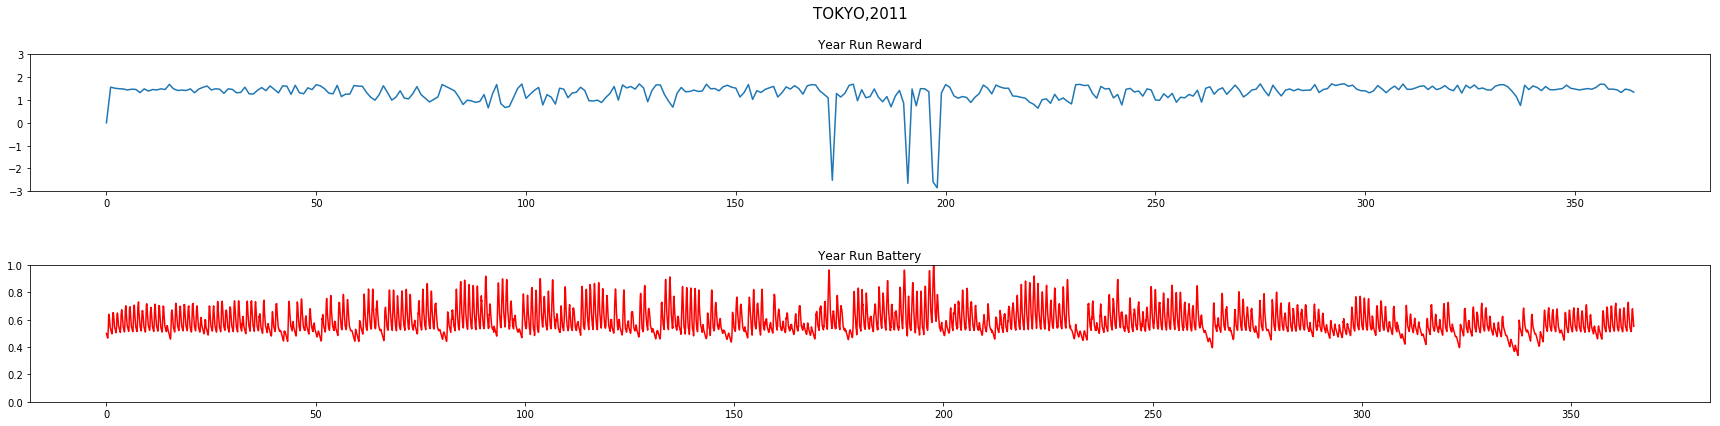

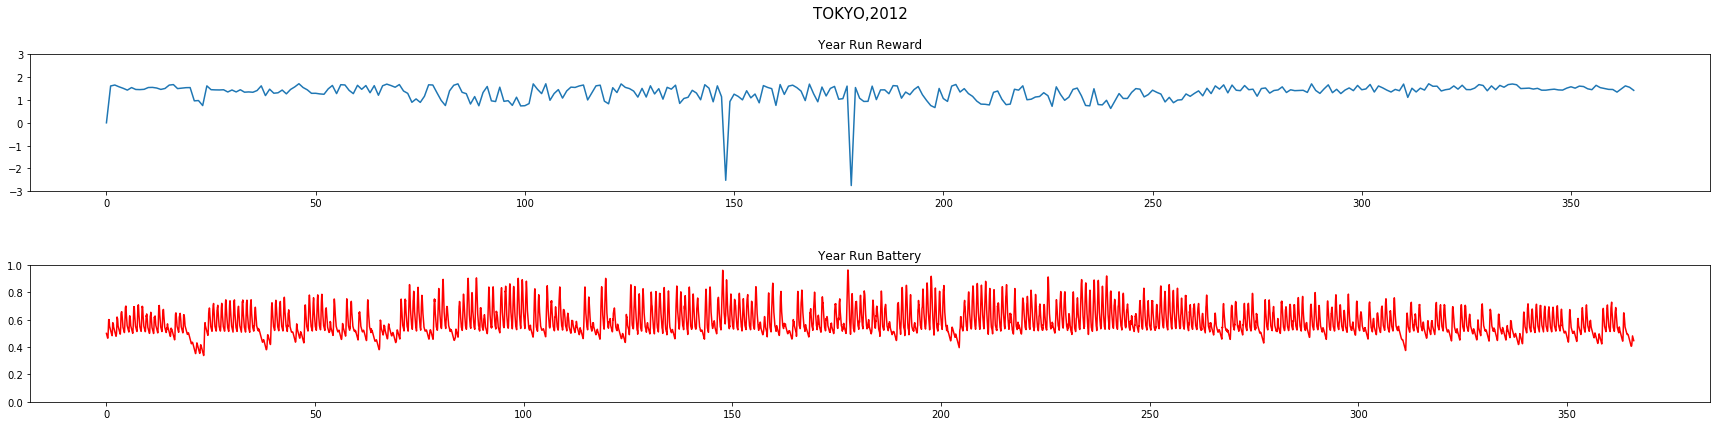

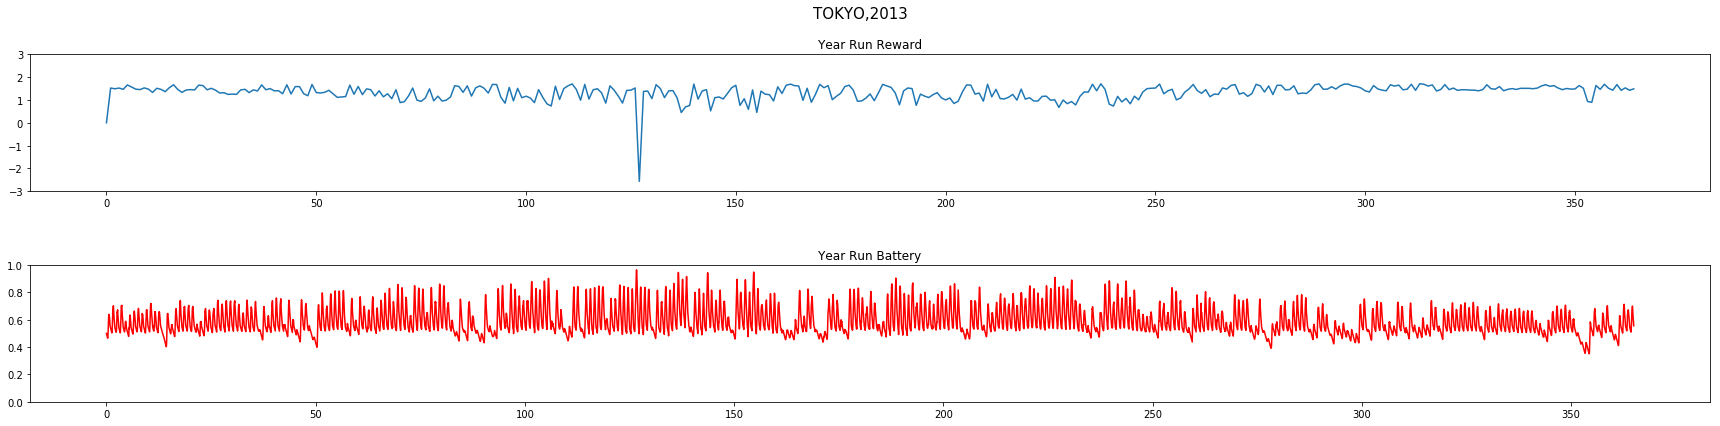

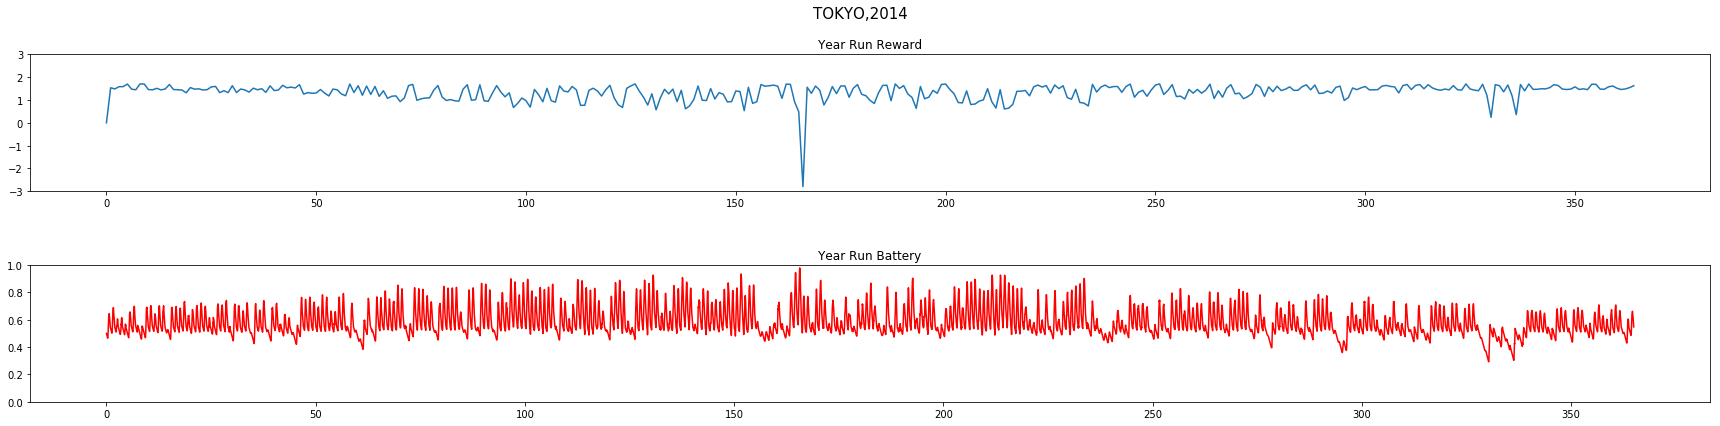

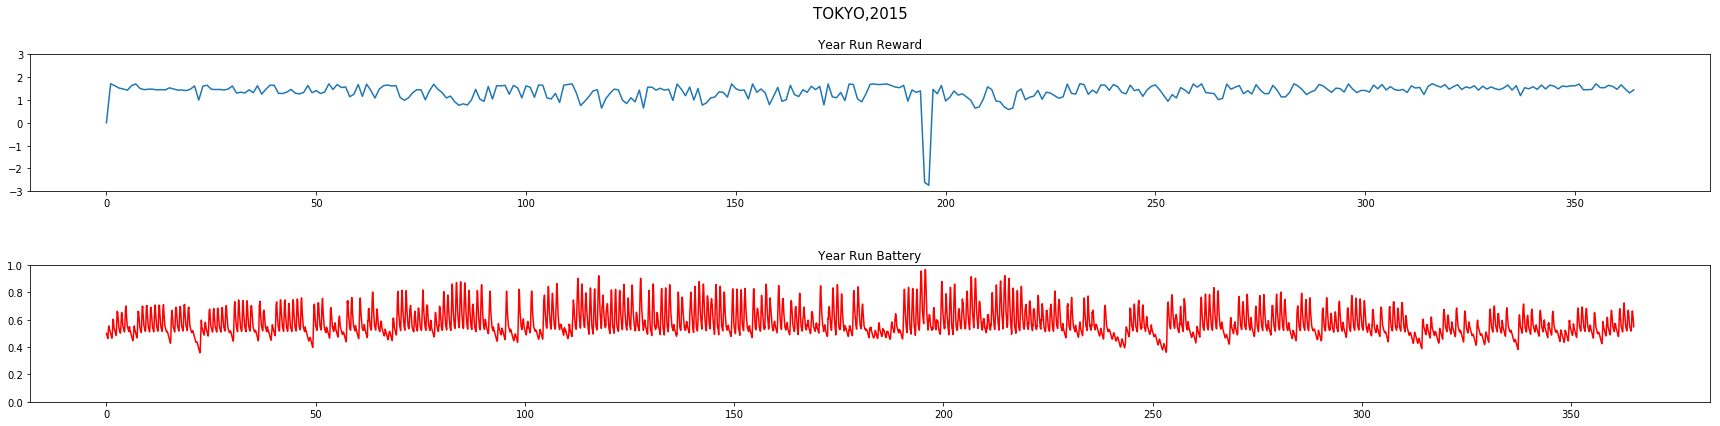

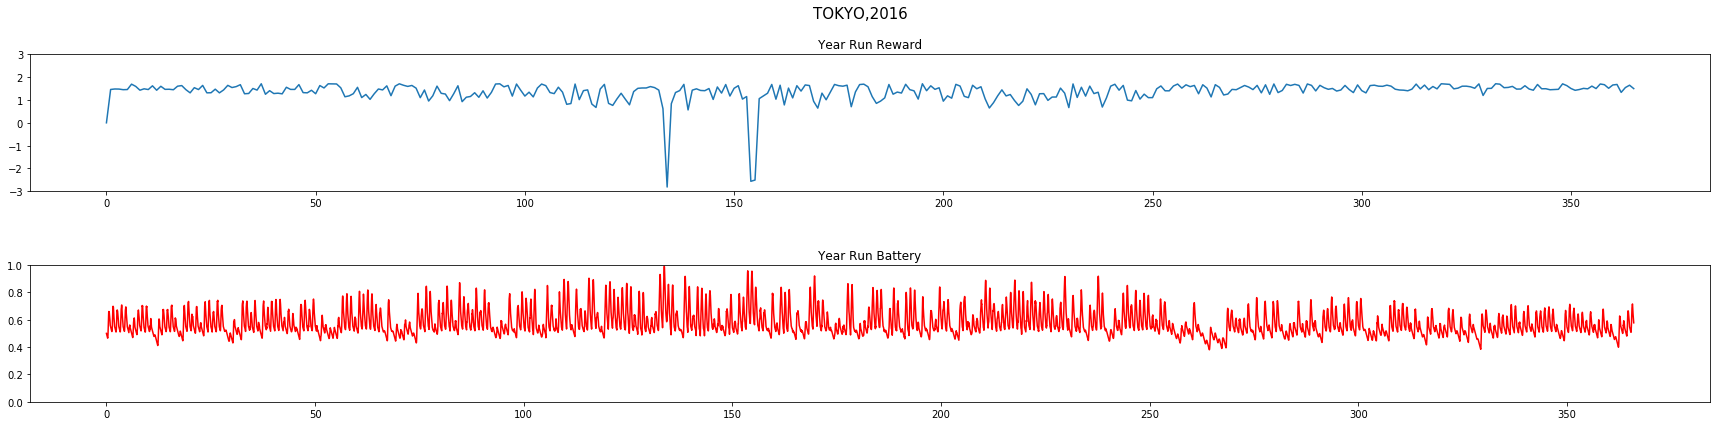

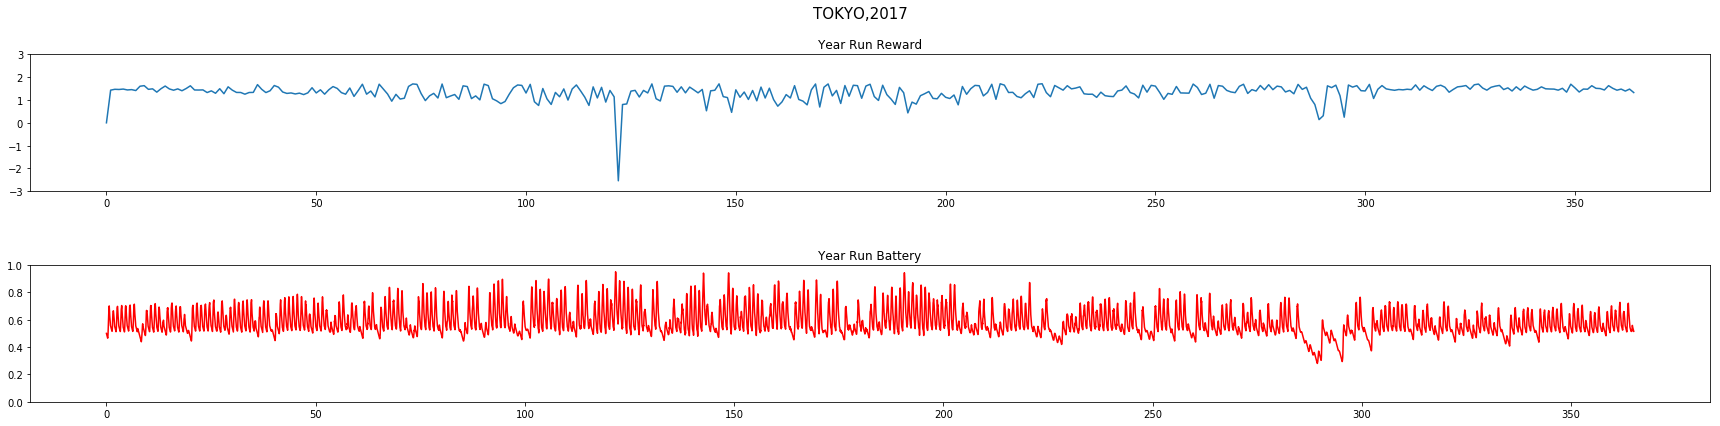

In [13]:
#END OF TRAINING PHASE
print("***MEASURING PERFORMANCE OF THE MODEL***")
results = np.empty(4)
LOCATION = 'tokyo'
for YEAR in np.arange(2000,2018):
    capm      = CAPM(LOCATION,YEAR,shuffle=False, trainmode=False) #instantiate the CAPM class
    capm.eno  = ENO(LOCATION,YEAR, shuffle=False, day_balance=False) #instantiate the environment inside the CAPM class
    capm.HMAX = capm.eno.SMAX #maximum power output of solar cell is set in CAPM object using the value in ENO object

    s, r, day_end, year_end = capm.reset()
    yr_test_record = np.empty(4)

    while True:
        a = dqn.choose_greedy_action(stdize(s))
        yr_test_record = np.vstack((yr_test_record, [s[0],s[2],r, a])) #record battery, henergy, reward and action
        s_, r, day_end, year_end = capm.step(a)
        if year_end:
            break
        s = s_

    yr_test_record = np.delete(yr_test_record, 0, 0) #remove the first row which is garbage
    yr_test_reward_rec = yr_test_record[:,2]
    yr_test_reward_rec = yr_test_reward_rec[::24] #annual average reward
    results = np.vstack((results, [int(YEAR), np.mean(yr_test_reward_rec), int(capm.violation_counter), int(capm.batt_violations)]))
    
#     Plot the reward and battery for the entire year run
    title = LOCATION.upper() + ',' + str(YEAR)
    NO_OF_DAYS = capm.eno.NO_OF_DAYS
 
    fig = plt.figure(figsize=(24,6))
    fig.suptitle(title, fontsize=15)
    
    ax1 = fig.add_subplot(211)
    ax1.plot(yr_test_reward_rec)
    ax1.set_title("\n\nYear Run Reward")
    ax1.set_ylim([-3,3])
    
    ax2 = fig.add_subplot(212)
    ax2.plot(yr_test_record[:,0],'r')
    ax2.set_title("\n\nYear Run Battery")
    ax2.set_ylim([0,1])
    plt.sca(ax2)
    plt.xticks(np.arange(0, NO_OF_DAYS*24, 50*24),np.arange(0,NO_OF_DAYS,50))
    fig.tight_layout()
    plt.show()

In [14]:
results = np.delete(results,0,0)
print('YEAR\tAVG_RWD\t\tVIOLATIONS')
print('\t\t\tDAY\tBATT')

for x in np.arange(0,results.shape[0]):
    print('{}\t {}\t\t{}\t {}'.format(int(results[x,0]), np.around(results[x,1],2), int(results[x,2]), int(results[x,-1])))

YEAR	AVG_RWD		VIOLATIONS
			DAY	BATT
2000	 1.38		0	 0
2001	 1.39		0	 0
2002	 1.36		0	 0
2003	 1.38		0	 0
2004	 1.31		3	 0
2005	 1.35		0	 0
2006	 1.4		0	 0
2007	 1.35		2	 0
2008	 1.36		0	 0
2009	 1.38		0	 0
2010	 1.35		1	 0
2011	 1.32		4	 1
2012	 1.33		2	 0
2013	 1.33		1	 0
2014	 1.34		1	 0
2015	 1.36		2	 0
2016	 1.37		3	 0
2017	 1.34		1	 0


In [15]:
print('Device: ', dqn.device)
print('Run time: {}'.format(datetime.now() - tic))

Device:  cpu
Run time: 0:23:52.377406
